# Analysis of custom filters

## Aim of this notebook

Analyzing the pre-filtered fragment library (`data/fragment_library` and pre-filtering applied), the reduced fragment library (`data/fragment_library_reduced`) and the custom filtered fragment library (`data/fragment_library_custom_filtered`) by fragment library size, chemical space, fragment subpocket specificity, molecular properties, and custom filtered fragment library size development during filtering.


## Table of contents
1. Load the fragment libraries

    1.1. Load pre-filtered fragment library
    
    1.2. Load reduced fragment library
    
    1.3. Load custom filtered fragment library
    
    1.4. Check which fragments from the pre-filtered fragment library are contained in the subsets
    

2. Comparing the chemical space spanned by the libraries
    
    2.1. Comparing fragment library sets
    * Pre-filtered fragment library vs. reduced fragment library
    * Pre-filtered fragment library vs. custom filtered fragment library
    * Pre-filtered fragment library vs. reduced fragment library vs. custom filtered fragment library
    
    
    2.2. Comparing single custom filtering steps



3. Fragment subpocket specificity

    3.1. Pre-filtered fragment library

    3.2. Reduced fragment library
    
    3.3. Custom filtered fragment library

    3.4. Compare cluster sizes for all subsets
    
    3.5. Compare most common fragments in complete fragment library with the clustered fragments in custom filtered fragment library



4. Connection frequency between subpockets

    4.1. Pre-filtered fragment library
    
    4.2. Reduced fragment library
    
    4.3. Custom filtered fragment library
    

5. Fragment similarity per subpocket


6. Fragment properties

    6.1. For each library subset

    6.2. For every custom filter step

7. Development of number of fragments per subpocket during custom filtering

## Imports and preprocessing

In [1]:
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools
from IPython.core.display import HTML

from kinfraglib import filters, utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

### Define global paths

**Note:** If you want to run this analysis for your own created custom fragment library please adapt `PATH_DATA_CUSTOM` to the folder containing your custom fragment library, e.g. `PATH_DATA_CUSTOM = PATH_DATA / "fragment_library_custom_filtered/YYYY-MM-DD_HH-MM-SS`"

In [4]:
# Path to data
HERE = Path().resolve()
PATH_DATA = HERE / "../../data"
PATH_DATA_CUSTOM = PATH_DATA / "fragment_library_custom_filtered"

## 1. Load the fragment libraries
*  1.1. Load pre-filtered fragment library
*  1.2. Load reduced fragment library
*  1.3. Load custom filtered fragment library
*  1.4. Check which fragments from the pre-filtered fragment library are contained in the subsets

**Pre-filtered fragment library:** Fragment library without duplicates, unfragmented ligands, fragments only connecting to pool X and fragments in pool X. `fragment_library`

**Reduced fragment library:** Pre-filtered fragment library, without AP fragments which are not hinge like and chose a diverse subset using Butina Clustering. `fragment_library_reduced`

**Custom fragment library:** Pre-filtered fragment library excluding fragments filtered out by unwanted substructures, drug likeness, synthesizability and pairwise retrosynthesizability. `fragment_library_custom_filtered`

### 1.1. Load pre-filtered fragment library
Fragment library without duplicates, unfragmented ligands, fragments only connecting to pool X and fragments in pool X.

In [5]:
fragment_library_orig = utils.read_fragment_library(PATH_DATA / "fragment_library")
fragment_library = filters.prefilters.pre_filters(fragment_library_orig)
pd.concat(fragment_library).shape

(2859, 18)


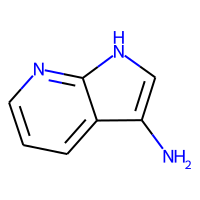
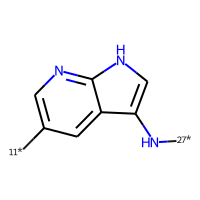
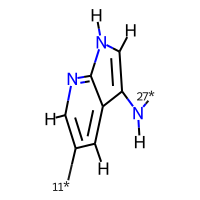
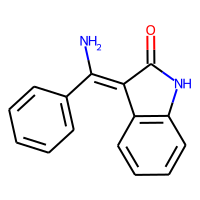
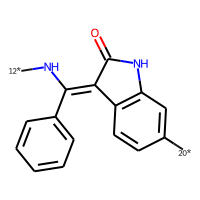
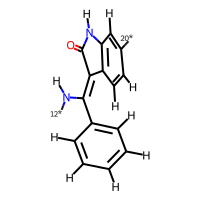
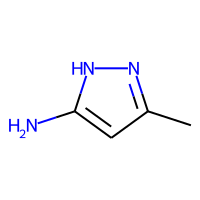
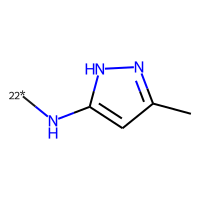
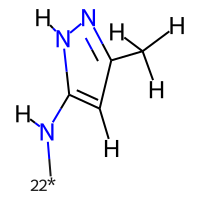
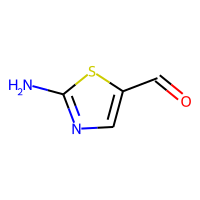
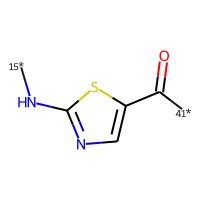
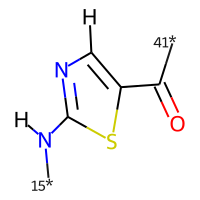
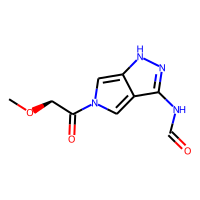
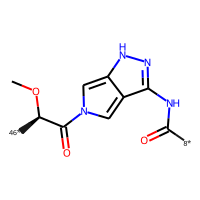
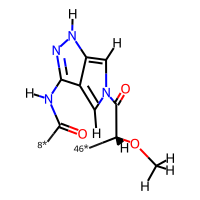

In [6]:
HTML(fragment_library["AP"].head().to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

### 1.2. Load reduced fragment library
Pre-filtered fragment library, without AP fragments which are not hinge like and chose a diverse subset using Butina Clustering.

In [7]:
fragment_library_reduced = utils.read_fragment_library(PATH_DATA / "fragment_library_reduced")
pd.concat(fragment_library_reduced).shape

(624, 15)


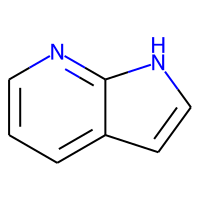
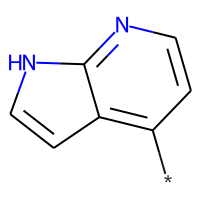
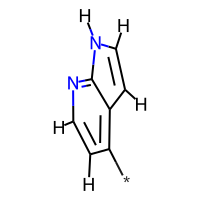
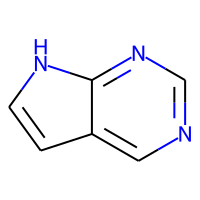
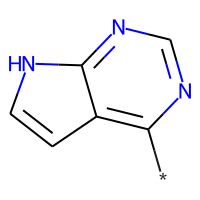
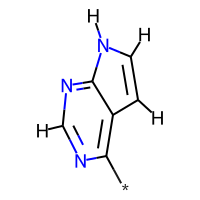
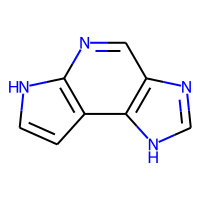
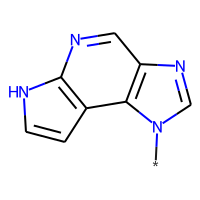
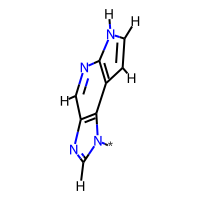
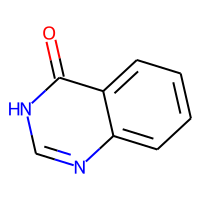
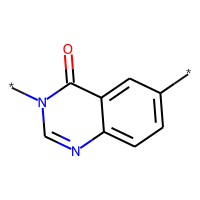
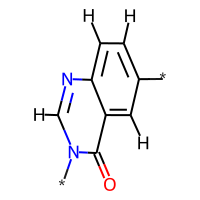
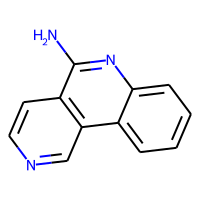
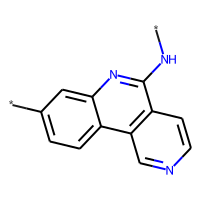
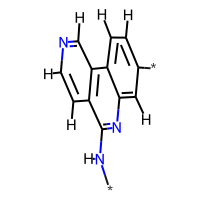

In [8]:
HTML(fragment_library_reduced["AP"].head().to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

### 1.3. Load custom filtered fragment library
Pre-filtered fragment library excluding fragments filtered out by unwanted substructures, drug likeness, synthesizability and pairwise retrosynthesizability filters.

In [9]:
fragment_library_custom = utils.read_fragment_library(PATH_DATA / "fragment_library_custom_filtered")
pd.concat(fragment_library_custom).shape

(388, 15)


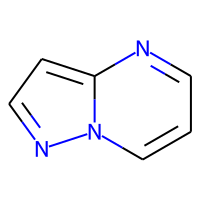
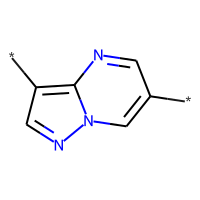
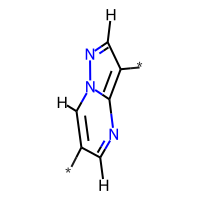
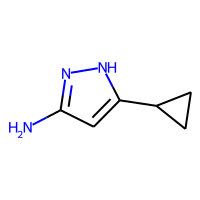
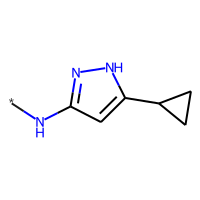
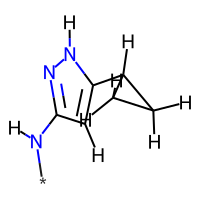
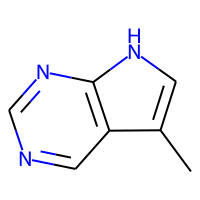
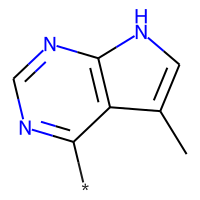
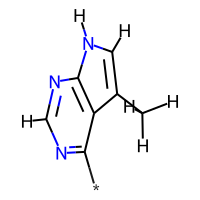
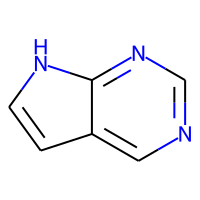
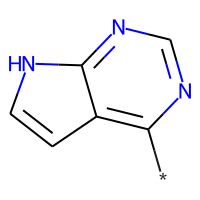
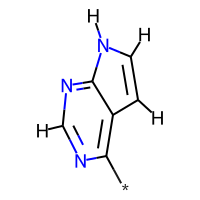
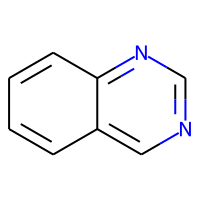
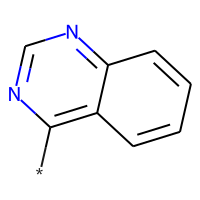
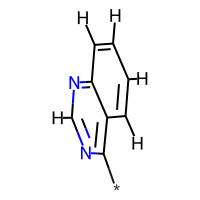

In [10]:
HTML(fragment_library_custom["AP"].head().to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

### 1.4. Check which fragments from the pre-filtered fragment library are contained in the subsets

In [11]:
fragment_library = filters.analysis.frag_in_subset(fragment_library, fragment_library_reduced, colname = "bool_reduced")

In [12]:
fragment_library = filters.analysis.frag_in_subset(fragment_library, fragment_library_custom, colname = "bool_custom")


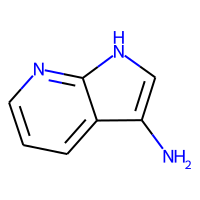
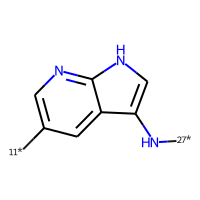
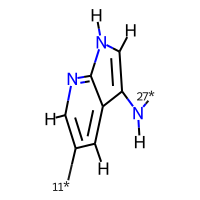
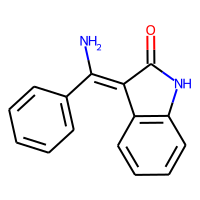
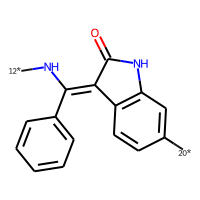
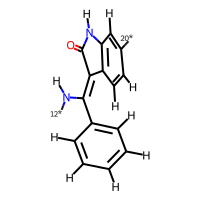
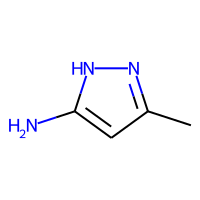
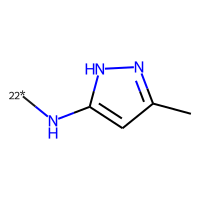
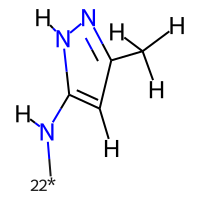
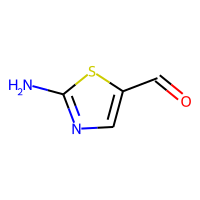
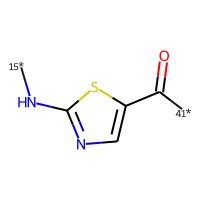
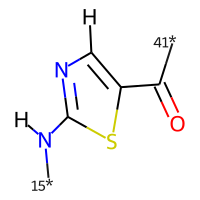
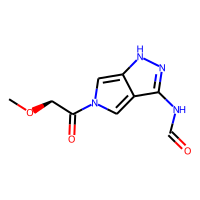
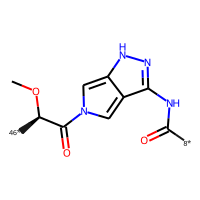
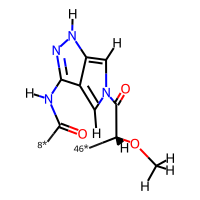

In [13]:
HTML(fragment_library["AP"].head().to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

Number of fragments in each subpocket for the three subsets.

In [14]:
num_fragments = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library, "pre-filtered"),
        filters.analysis.count_fragments(fragment_library_reduced, "reduced"),
        filters.analysis.count_fragments(fragment_library_custom, "custom"),
    ],
    axis=1,
)
num_fragments = pd.concat([num_fragments, num_fragments.sum().rename("Total").to_frame().T])
num_fragments

pre-filtered  reduced  custom
AP             1001      145     107
FP              862      192      97
SE              606      140      95
GA              306       93      79
B1               42       24       5
B2               42       30       5
Total          2859      624     388

## 2. Comparing the chemical space spanned by the libraries
* 2.1. Comparing fragment library sets
        - Pre-filtered fragment library vs. reduced fragment library
        - Pre-filtered ragment library vs. custom filtered fragment library
        - Pre-filtered fragment library vs. reduced fragment library vs. custom filtered fragment library
    
* 2.2. Comparing single custom filtering steps

The chemical space spanned by the fragment libraries will be analyzed using t-Distributed Stochastic Neighbor Embedding (t-SNE) plots, which can be used to visualize high dimensional data in a low dimensional space, showing clusters of similar molecules. 

We will use them to compare the included and excluded fragments in the fragment libraries and the filtering steps.

### 2.1. Comparing fragment library sets

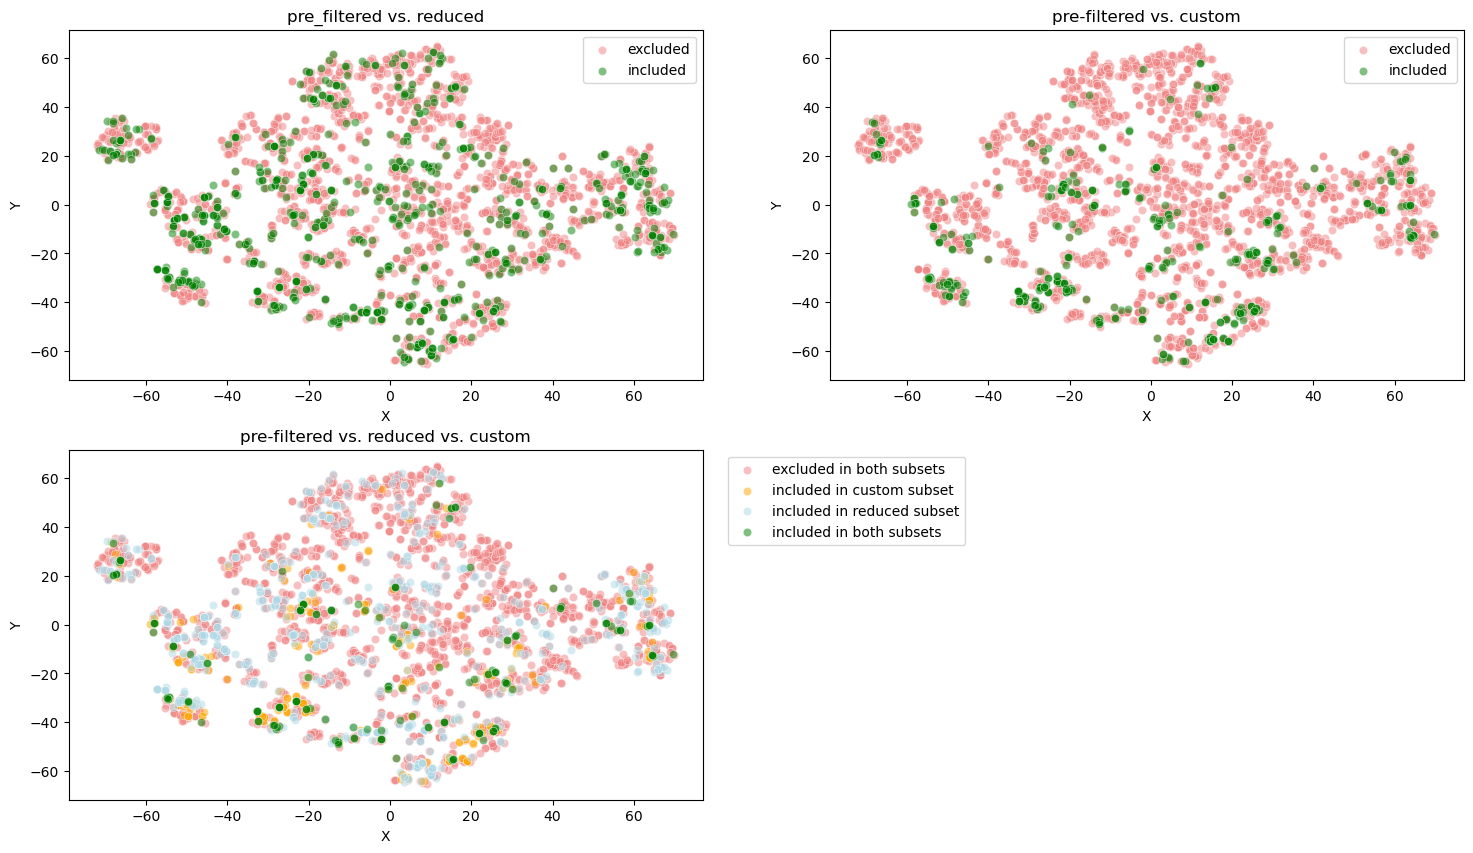

2859 Pre-filtered fragments.
        Number of fragments excluded in both datasets: 1856
        Number of fragments included in the custom dataset and excluded in the reduced dataset: 226
        Number of fragments included in the reduced dataset and excluded in the custom dataset: 605
        Number of fragments in both datasets: 172 


In [15]:
tsne_df = filters.plots.create_tsne_plots(fragment_library)

`tsne_df`: Dataframe containing the positions in the t-SNE-plot, booleans/integer if they are contained in a subset and the SMILES string of the fragment.
- `x` and `Y`
    - fragments positions calculated by the t-SNE method.
    
- `reduced`
    - boolean values if fragment is contained in the reduced subset
    
- `custom`
    - boolean values if fragment is contained in the custom subset
    
- `compare`
    - integer specifying  in which subset(s) the fragments are
        - 0: Excluded in both subsets
        - 1: Included in custom subset and excluded in reduced subset
        - 2: Included in reduced subset and excluded in custom subset
        - 3: Included in both subsets

Inspect molecules shown in t-SNE plots

In [16]:
tsne_df.head()

X          Y  reduced  custom  compare  \
0  41.267014 -13.753640        0       0        0   
1   7.932777   8.197802        0       0        0   
2  36.610126   6.832931        1       0        2   
3  27.800512  -4.882809        0       0        0   
4  31.346588  12.618166        0       0        0   

                             smiles  
0                 Nc1c[nH]c2ncccc12  
1  N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1  
2                    Cc1cc(N)[nH]n1  
3                     Nc1ncc(C=O)s1  
4     COCC(=O)n1cc2[nH]nc(NC=O)c2c1

Display first ten molecules contained in both subsets.

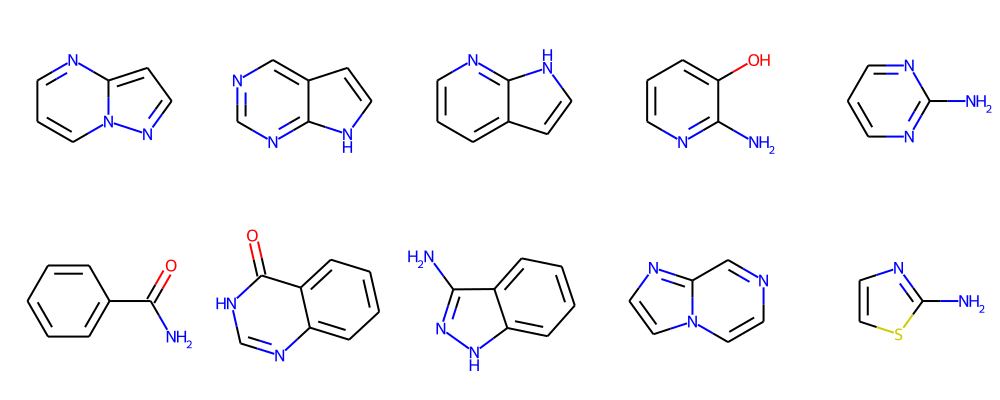

In [17]:
Draw.MolsToGridImage(
            [Chem.MolFromSmiles(smiles) for smiles in tsne_df[tsne_df["compare"]==3]["smiles"][0:10]],
            molsPerRow=5,
        )

### 2.2 Comparing single custom filtering steps

Read in file where single filtering step results are saved.

In [18]:
saved_filter_results = pd.read_csv(PATH_DATA_CUSTOM / "custom_filter_results.csv")
saved_filter_results.head()

smiles subpocket  bool_pains  bool_brenk  \
0                 Nc1c[nH]c2ncccc12        AP           1           1   
1  N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1        AP           1           0   
2                    Cc1cc(N)[nH]n1        AP           1           1   
3                     Nc1ncc(C=O)s1        AP           1           0   
4     COCC(=O)n1cc2[nH]nc(NC=O)c2c1        AP           1           0   

   bool_ro3  bool_qed       qed  bool_bb  bool_syba       syba  
0         1         1  0.565900        1          1  30.950959  
1         1         1  0.747185        0          1  17.682659  
2         1         0  0.488854        1          1  15.727015  
3         1         1  0.561340        1          1  12.789242  
4         0         1  0.723961        0          1  14.653939

Analyze which fragments in the chemical space are rejected and accepted by the single filters.

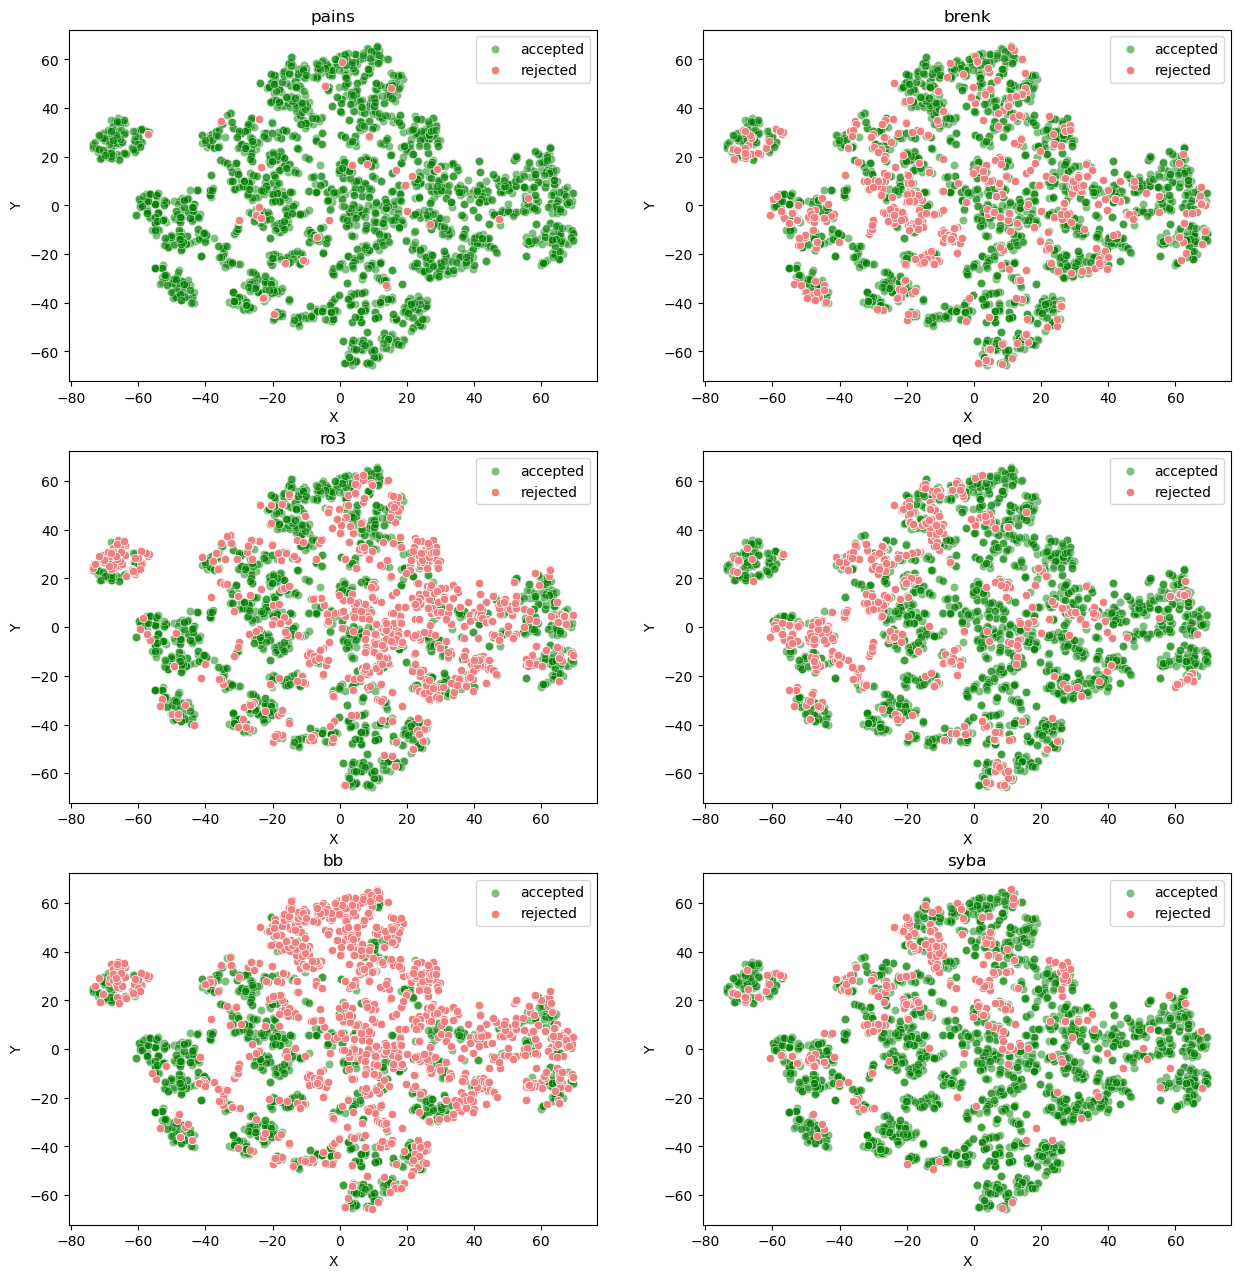

In [19]:
tsne_df_filters = filters.plots.create_tsne_plots_filters(fragment_library, saved_filter_results)

## 3. Fragment subpocket specificity

Cluster the fragments contained in the complete subset using Butina clustering with a similarity cut-off of 0.6 using RDKit fingerprints and a Tanimoto distance matrix calculated using the RDKit fingerprints.
Afterwards, the information is added in which subpockets the clustered fragments are found, to check which fragments only occur in one subpocket and are more subpocket specific and which are less specific and occur in all subpockets.

* 3.1. Pre-filtered fragment library
* 3.2. Reduced fragment library
* 3.3. Custom filtered fragment library
* 3.4. Compare cluster sizes for all subsets
* 3.5. Compare most common fragments in complete fragment library with most specific fragments in custom filtered fragment library

### 3.1. Pre-filtered fragment library
Applied analyses:
- Clustering
- Inspect clusters for all subpockets
- Inspect clusters only for a single subpocket (AP)
- Inspect fragments appearing in all subpockets
- Inspect fragments only appearing in one subpocket


In [20]:
clustered_fragments = filters.analysis.cluster_fragment_library(fragment_library)

Number of molecules: 2506
Threshold:  0.6
Number of clusters:  458
# Clusters with only 1 molecule:  207
# Clusters with more than 5 molecules:  94
# Clusters with more than 25 molecules:  20
# Clusters with more than 100 molecules:  2



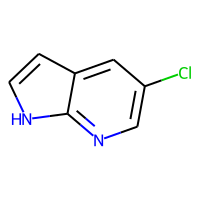
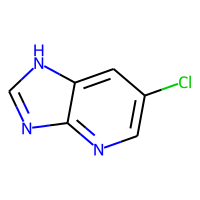
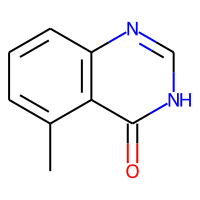

In [21]:
HTML(clustered_fragments.head(3).to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

Legend: cluster ID | subpocket count | subpockets


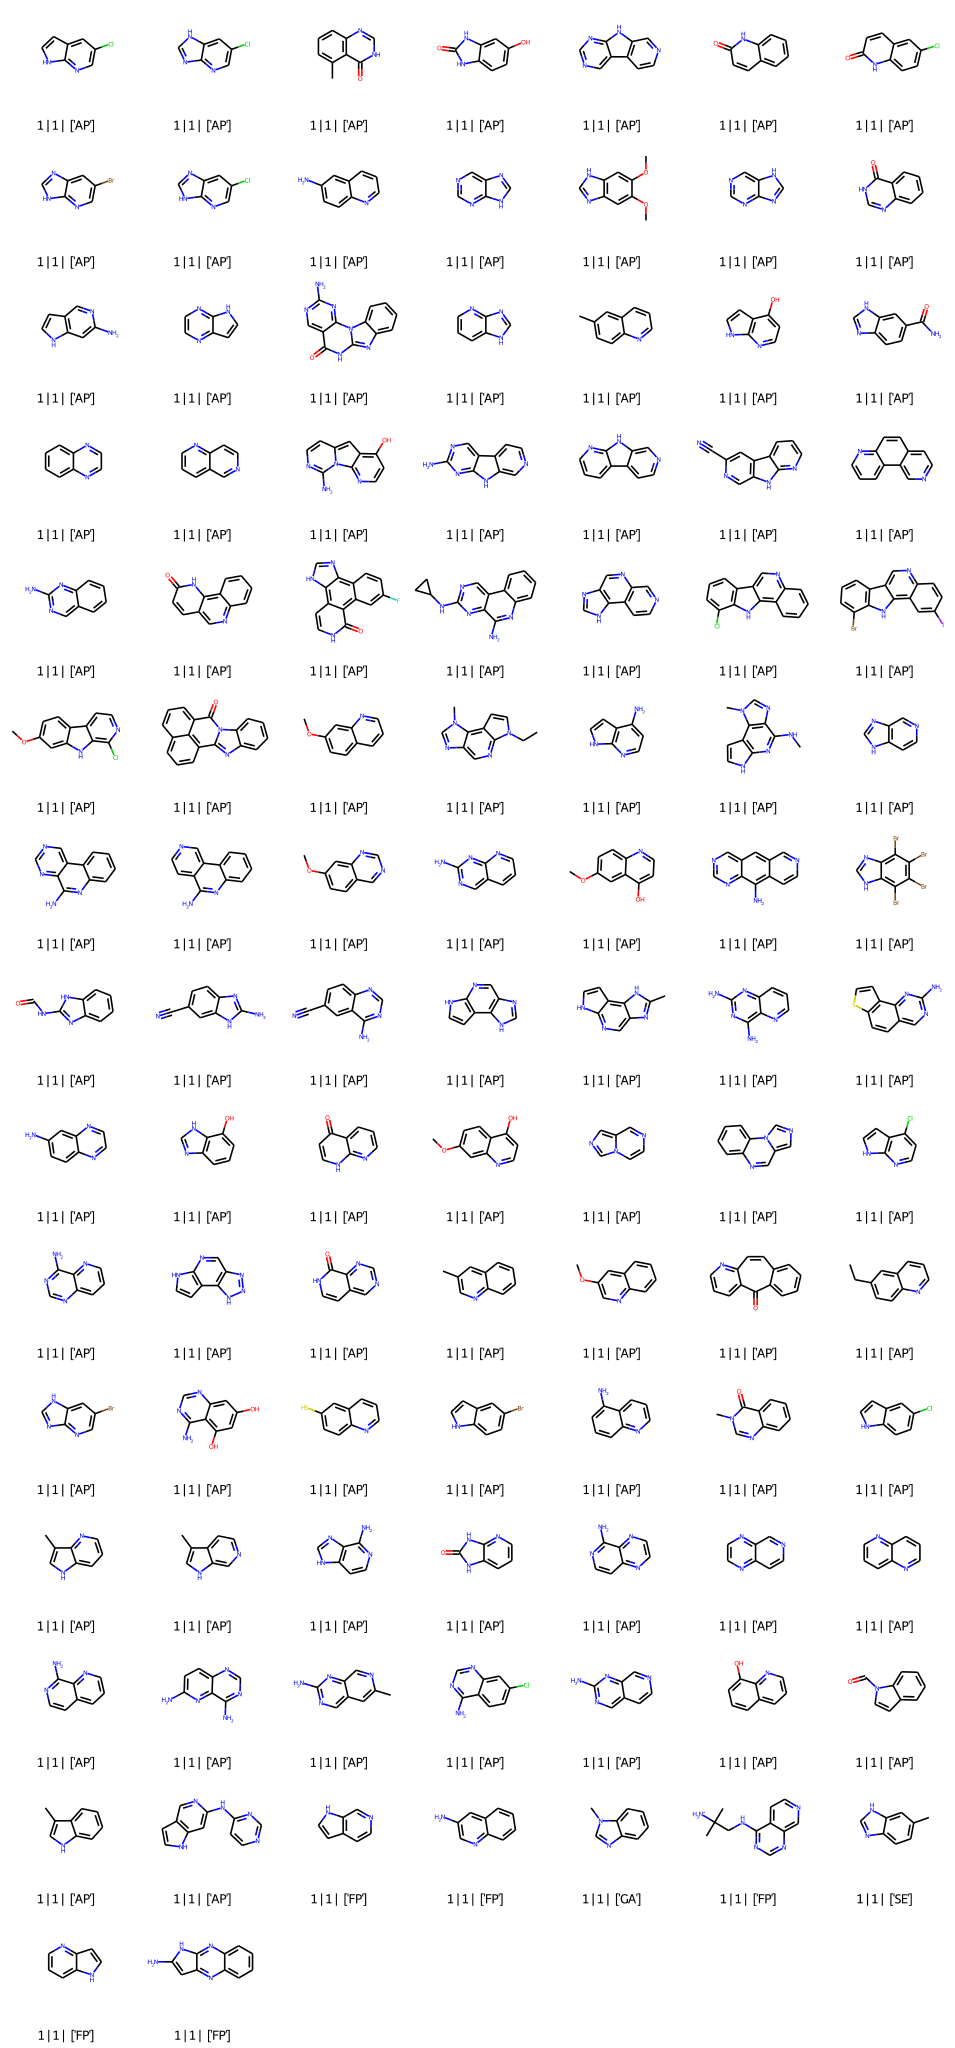

In [22]:
filters.plots.draw_clusters(clustered_fragments[:100], show_subpockets=True)

Inspect clusters for fragments contained in AP subpocket

Legend: cluster ID | subpocket count


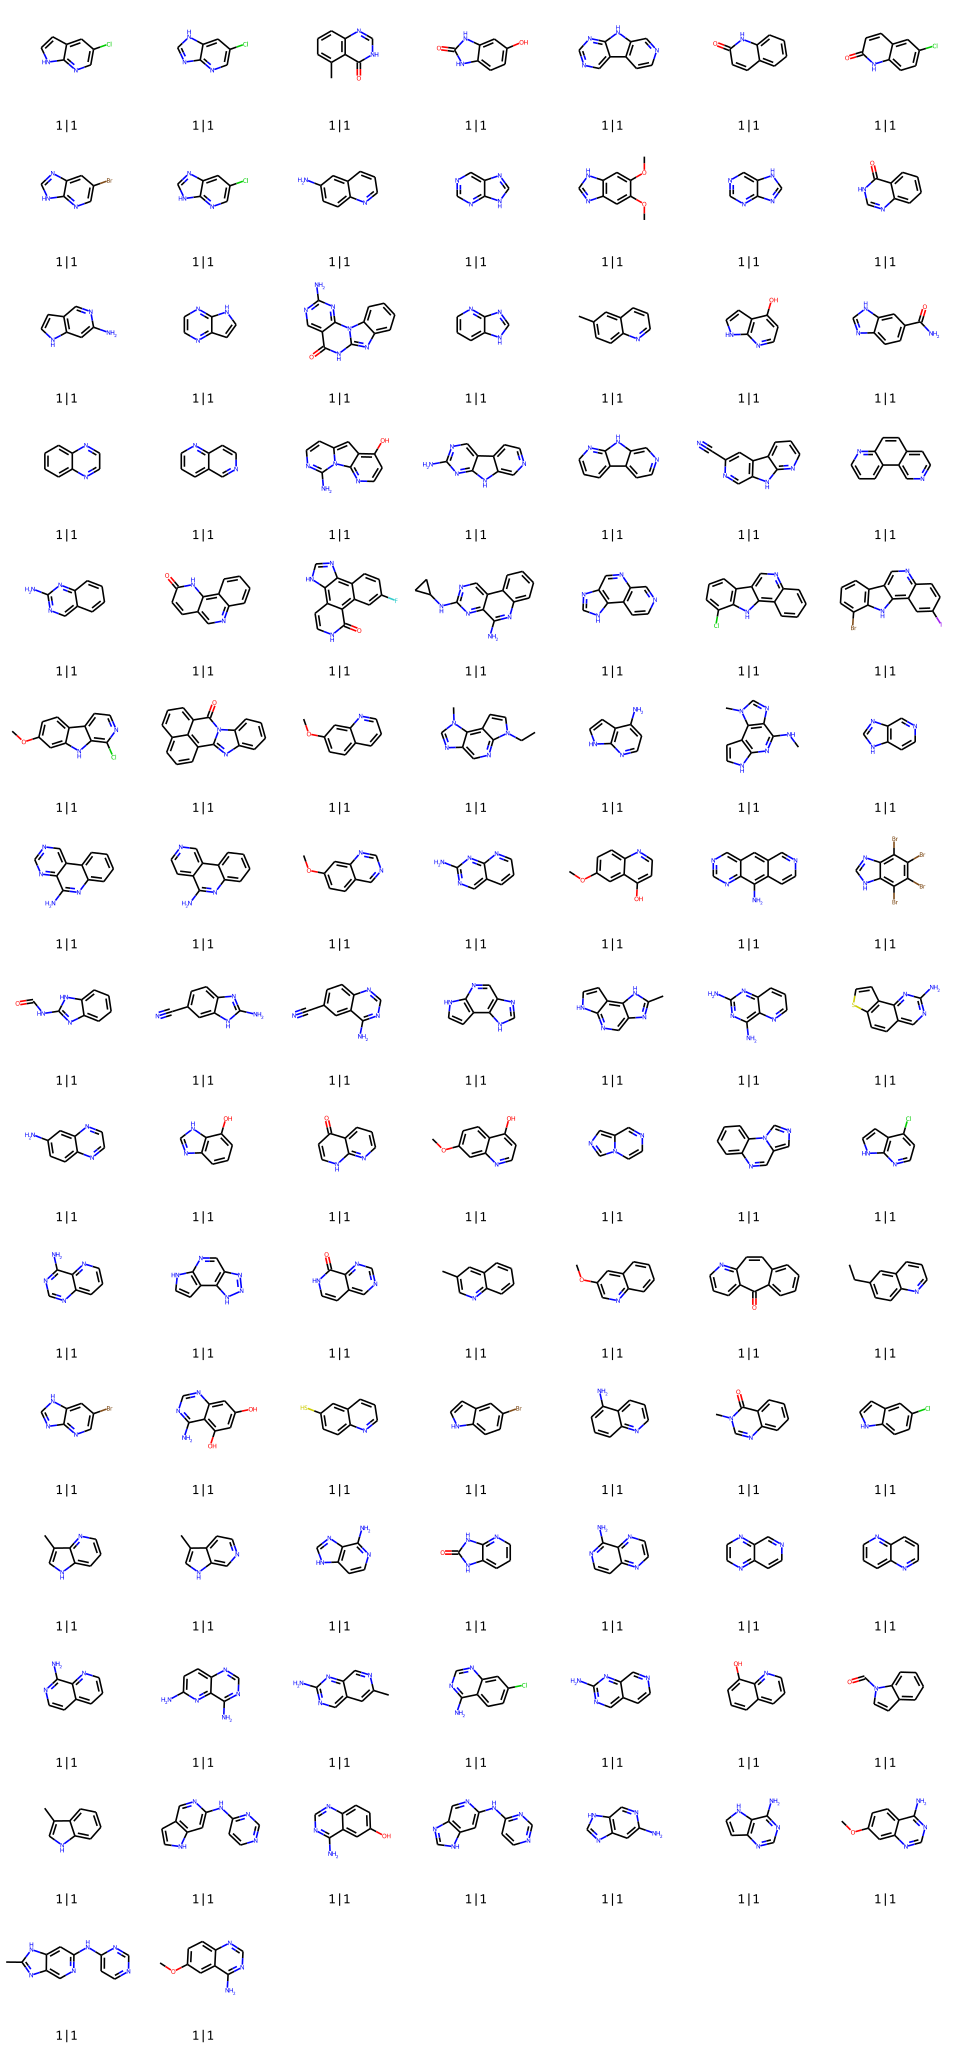

In [23]:
clustered_fragments_AP = clustered_fragments[clustered_fragments["subpockets"].astype(str).str.contains("AP")]
filters.plots.draw_clusters(clustered_fragments_AP[:100])

Are there fragments appearing in all 6 subpockets (not subpocket specific)?

In [24]:
clustered_fragments[clustered_fragments ["subpocket_count"]==6].shape

(3, 7)


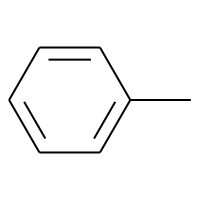
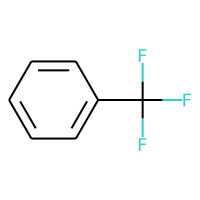
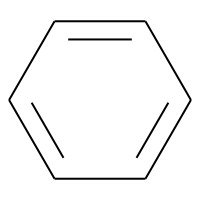

In [25]:
HTML(clustered_fragments[clustered_fragments ["subpocket_count"]==6].head(3).to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

Are there fragments appearing only in one subpocket (subpocket specific)?

In [26]:
clustered_fragments[clustered_fragments["subpocket_count"]==1].shape

(2286, 7)


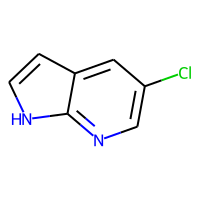
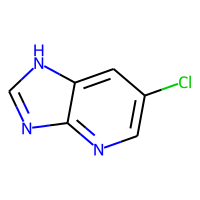
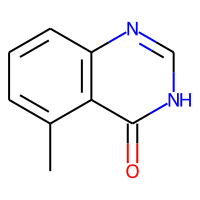

In [27]:
HTML(clustered_fragments[clustered_fragments ["subpocket_count"]==1].head(3).to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

### 3.2. Reduced fragment library
Applied analyses:
- Clustering
- Inspect clusters for all subpockets
- Inspect clusters only for a single subpocket (AP)
- Inspect fragments appearing in all subpockets
- Inspect fragments only appearing in one subpocket

In [28]:
clustered_fragments_reduced = filters.analysis.cluster_fragment_library(fragment_library_reduced)

Number of molecules: 540
Threshold:  0.6
Number of clusters:  257
# Clusters with only 1 molecule:  176
# Clusters with more than 5 molecules:  20
# Clusters with more than 25 molecules:  0
# Clusters with more than 100 molecules:  0



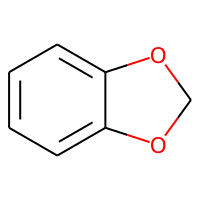
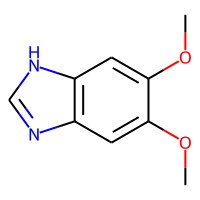
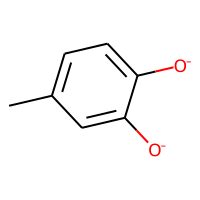

In [29]:
HTML(clustered_fragments_reduced.head(3).to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

Legend: cluster ID | subpocket count | subpockets


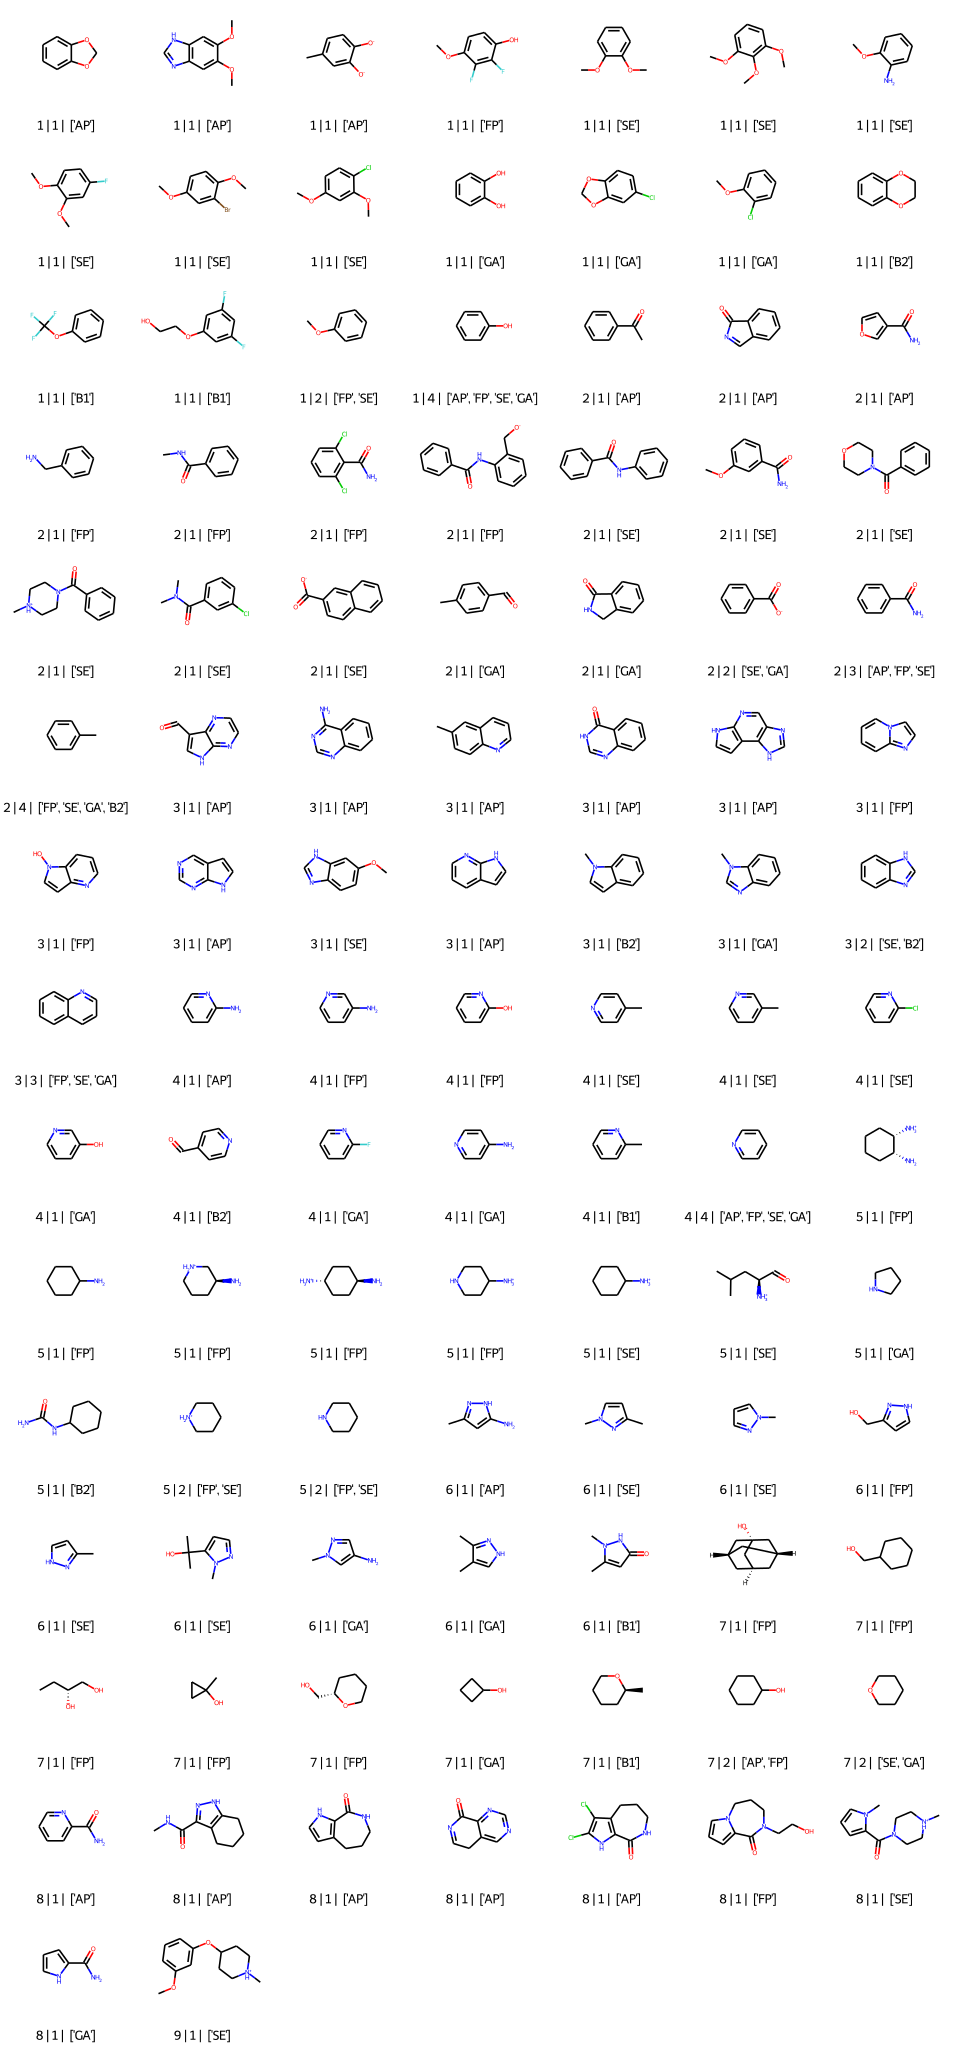

In [30]:
filters.plots.draw_clusters(clustered_fragments_reduced[:100], show_subpockets=True)

Inspect clusters for fragments contained in AP subpocket

Legend: cluster ID | subpocket count


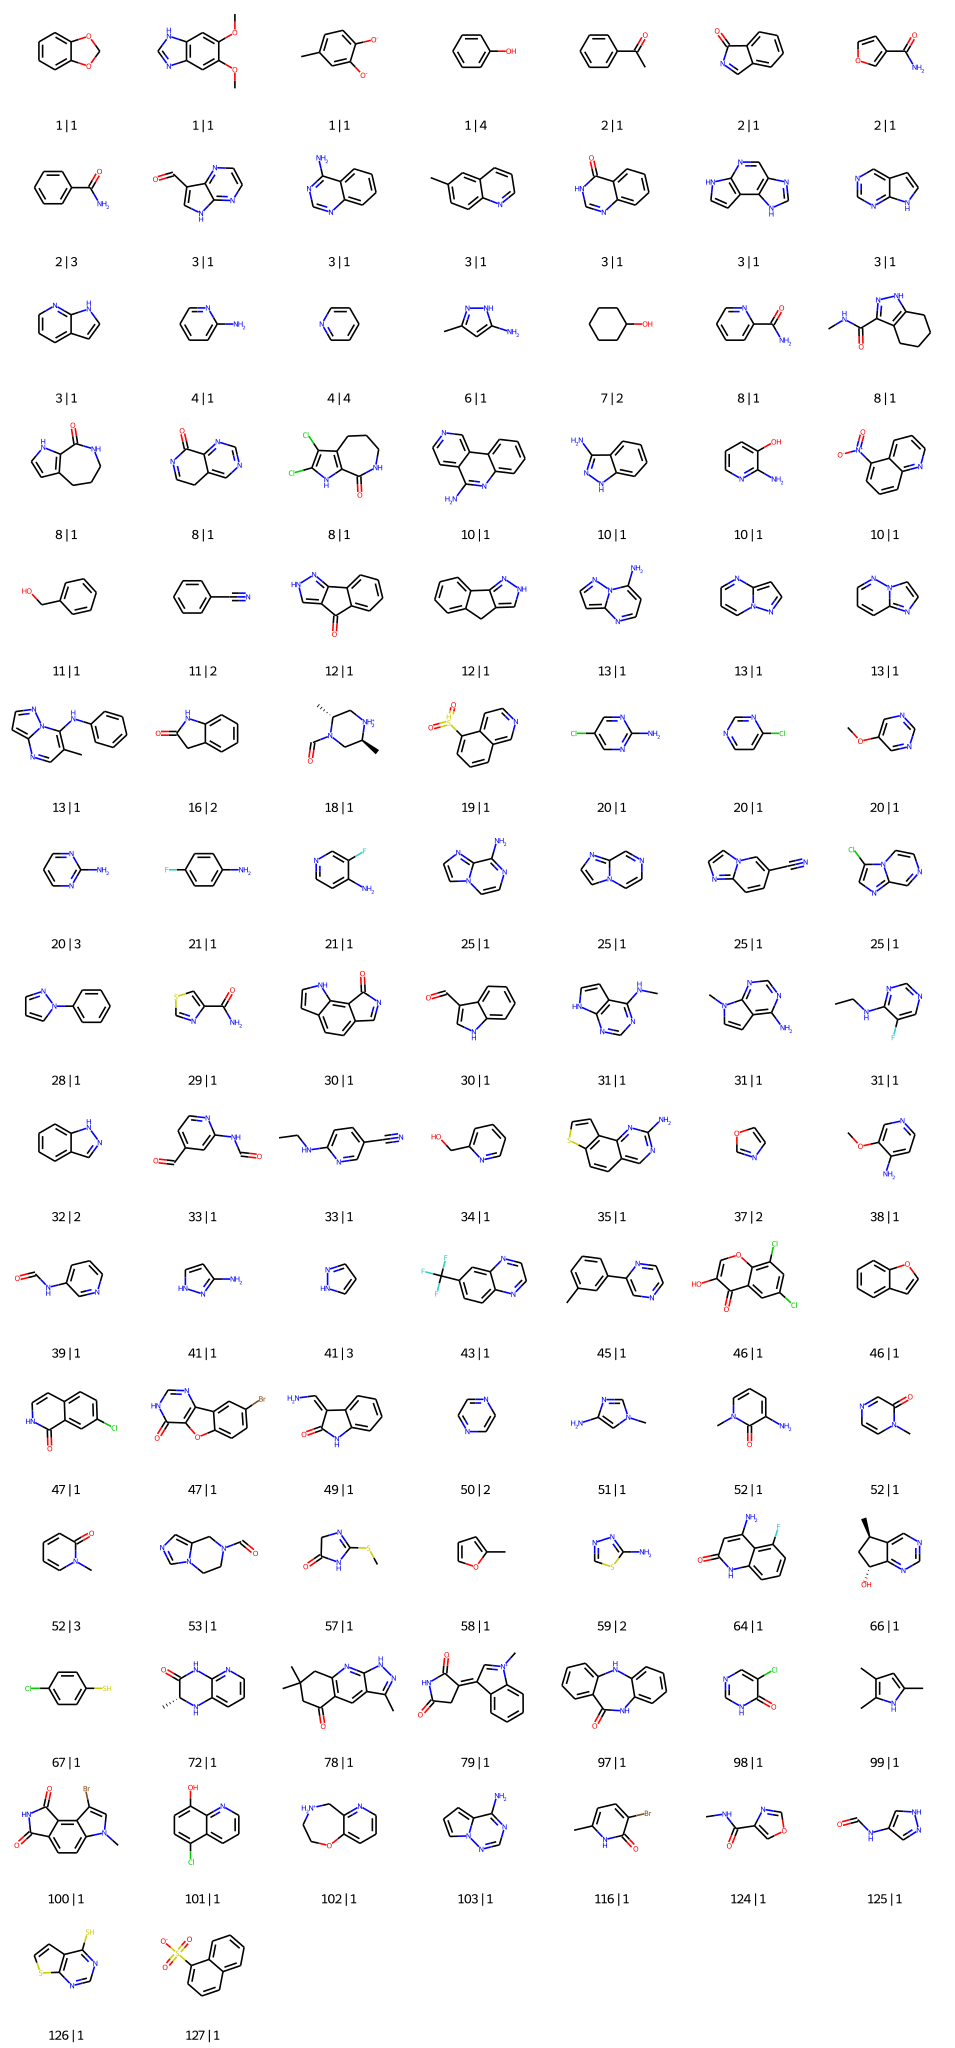

In [31]:
clustered_fragments_reduced_AP = clustered_fragments_reduced[clustered_fragments_reduced["subpockets"].astype(str).str.contains("AP")]
filters.plots.draw_clusters(clustered_fragments_reduced_AP[:100])

Are there fragments appearing in all 6 subpockets?

In [32]:
clustered_fragments_reduced[clustered_fragments_reduced["subpocket_count"]==6].shape

(0, 7)

Are there fragments appearing only in one subpocket?

In [33]:
clustered_fragments_reduced[clustered_fragments_reduced["subpocket_count"]==1].shape

(486, 7)


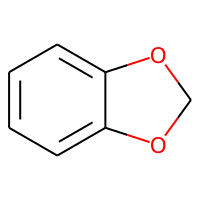
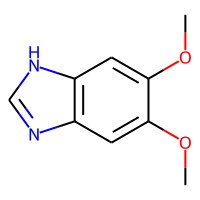
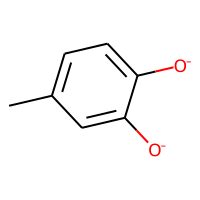

In [34]:
HTML(clustered_fragments_reduced[clustered_fragments_reduced["subpocket_count"]==1].head(3).to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

### 3.3. Custom filtered fragment library
Applied analyses:
- Clustering
- Inspect clusters for all subpockets
- Inspect clusters only for a single subpocket (AP)
- Inspect fragments appearing in all subpockets
- Inspect fragments only appearing in one subpocket

In [35]:
clustered_fragments_custom = filters.analysis.cluster_fragment_library(fragment_library_custom)

Number of molecules: 282
Threshold:  0.6
Number of clusters:  76
# Clusters with only 1 molecule:  38
# Clusters with more than 5 molecules:  11
# Clusters with more than 25 molecules:  3
# Clusters with more than 100 molecules:  0



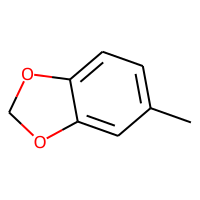
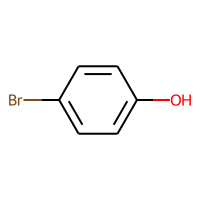
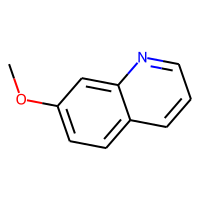

In [36]:
HTML(clustered_fragments_custom.head(3).to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

Inspect clusters for all subpockets

Legend: cluster ID | subpocket count | subpockets


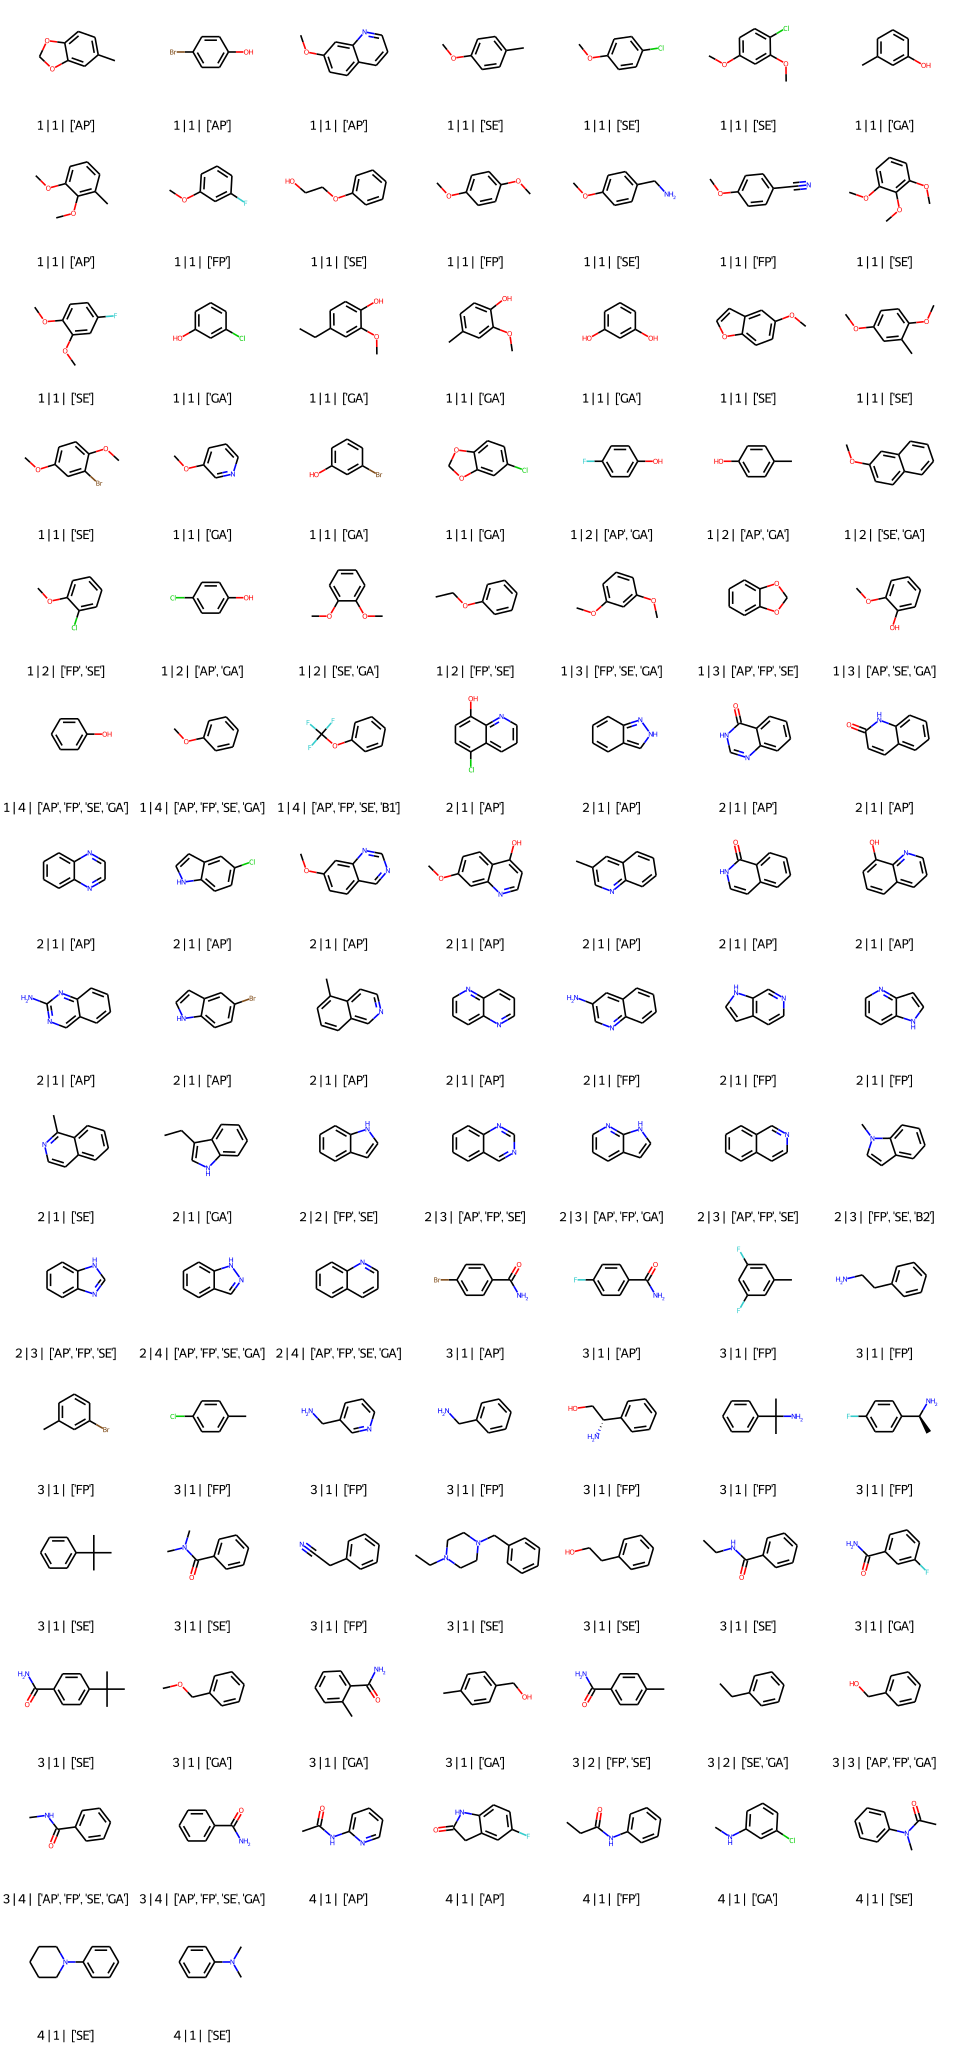

In [37]:
filters.plots.draw_clusters(clustered_fragments_custom[:100], show_subpockets=True)

Inspect clusters for fragments contained in AP subpocket

Legend: cluster ID | subpocket count


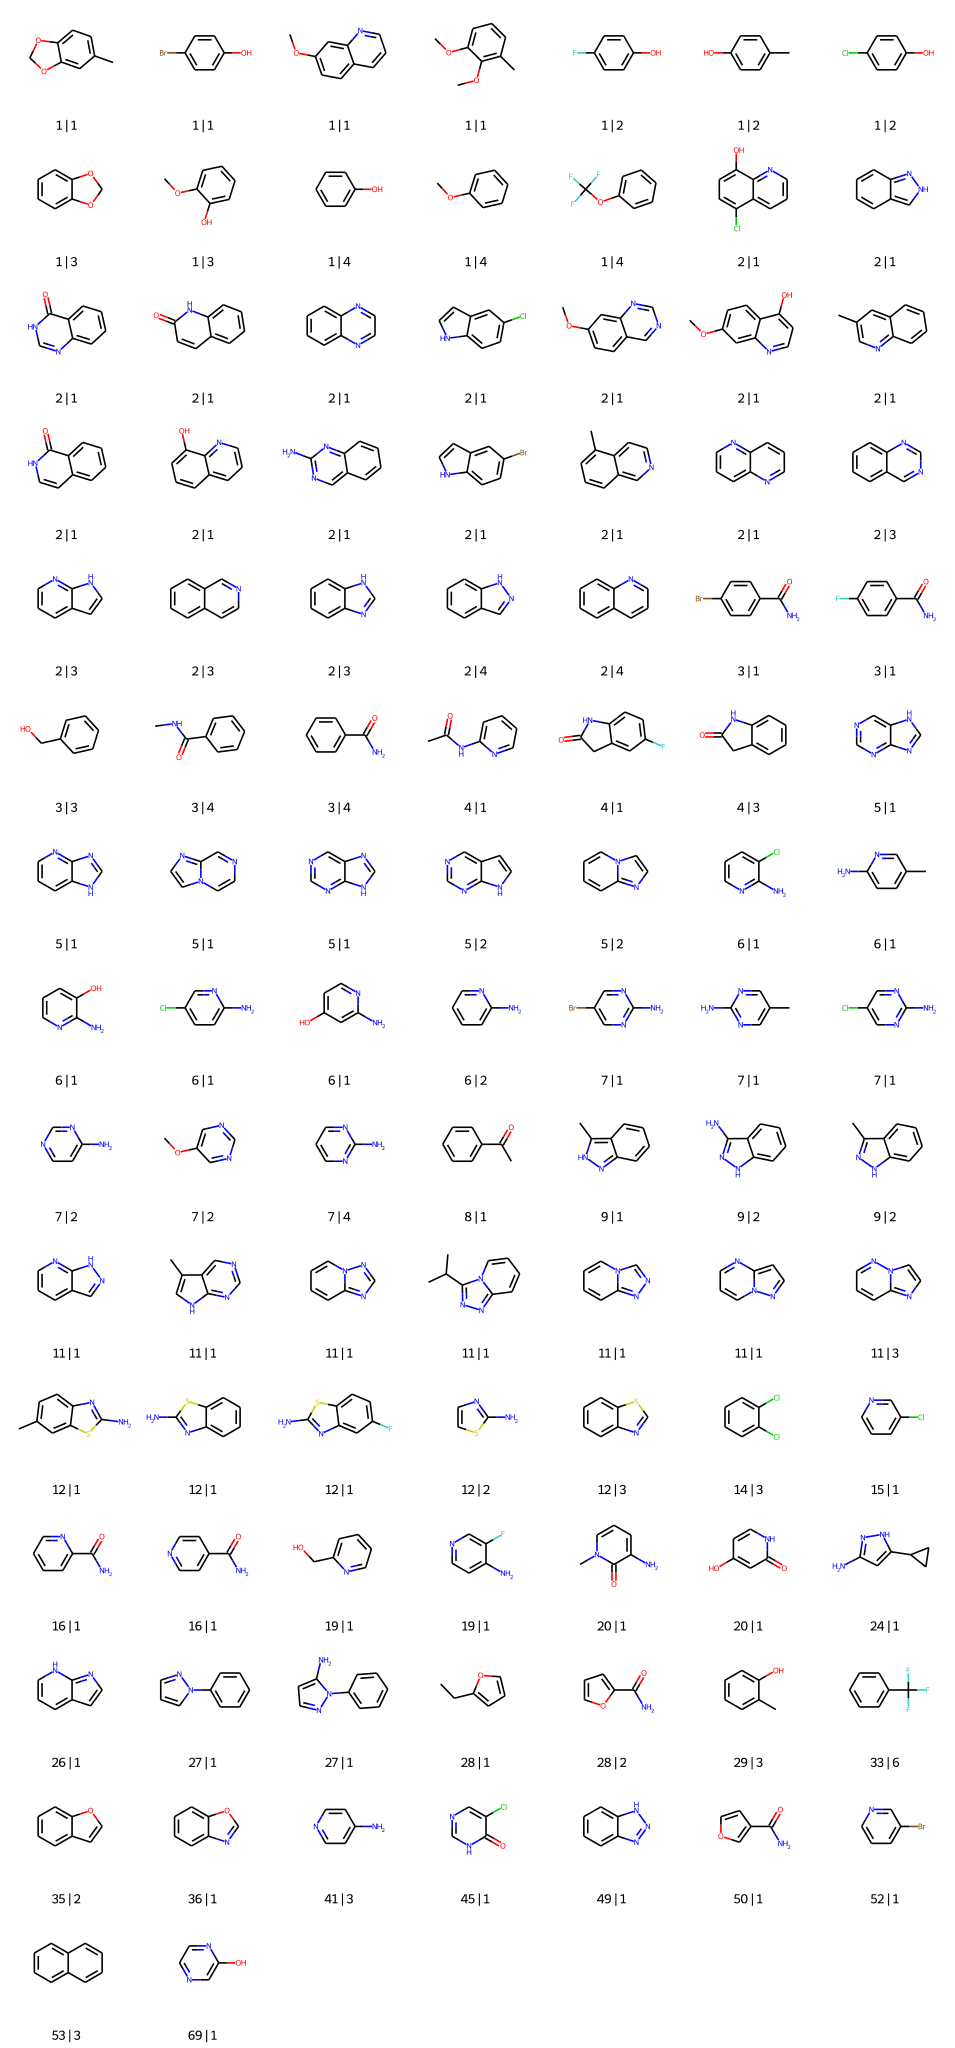

In [38]:
clustered_fragments_custom_AP = clustered_fragments_custom[clustered_fragments_custom["subpockets"].astype(str).str.contains("AP")]
filters.plots.draw_clusters(clustered_fragments_custom_AP[:100])

Are there fragments appearing in all 6 subpockets?

In [39]:
clustered_fragments_custom[clustered_fragments_custom["subpocket_count"]==6].shape

(1, 7)


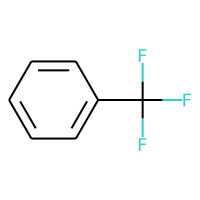

In [40]:
HTML(clustered_fragments_custom[clustered_fragments_custom["subpocket_count"]==6].to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

Are there fragments appearing only in one subpocket?

In [41]:
clustered_fragments_custom[clustered_fragments_custom["subpocket_count"]==1].shape

(220, 7)


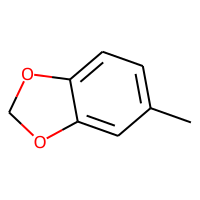
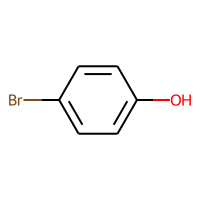
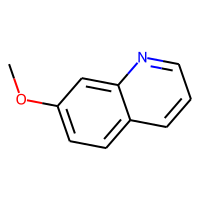
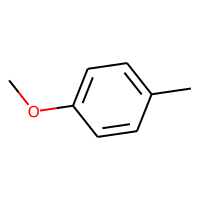
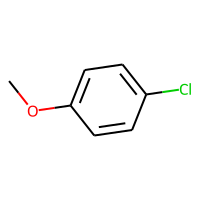

In [42]:
HTML(clustered_fragments_custom[clustered_fragments_custom["subpocket_count"]==1].head().to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

### 3.4. Compare cluster sizes for all subsets

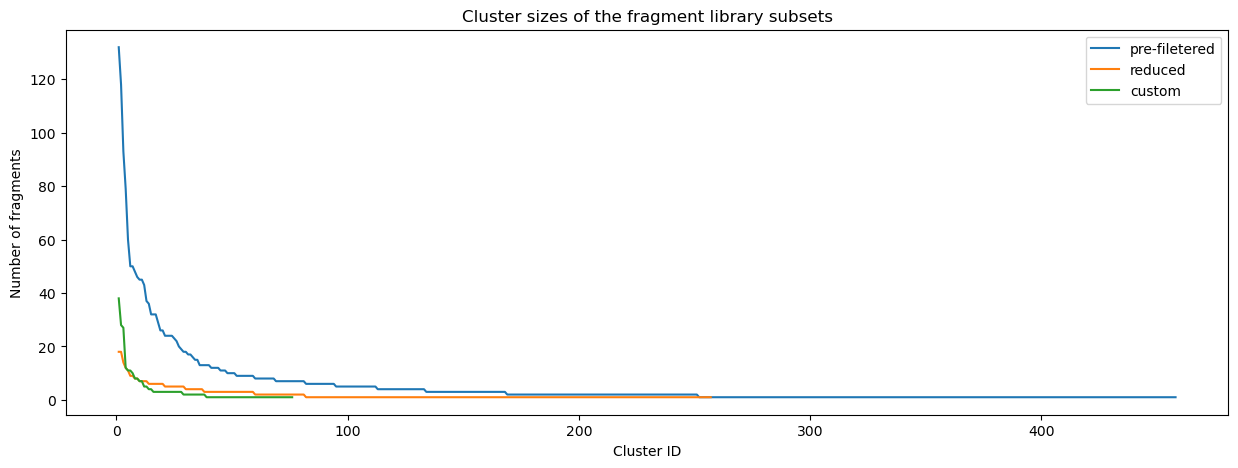

In [43]:
cluster_sizes = pd.DataFrame()
cluster_sizes["pre-filetered"] = clustered_fragments.groupby('cluster_id').size()
cluster_sizes["pre-filetered"].name = 'cluster_size'
cluster_sizes["reduced"] = clustered_fragments_reduced.groupby('cluster_id').size()
cluster_sizes["reduced"].name = "cluster_size"
cluster_sizes["custom"] = clustered_fragments_custom.groupby('cluster_id').size()
cluster_sizes["custom"].name = "cluster_size"

plt = cluster_sizes.plot(
    figsize=(15,5),
    title="Cluster sizes of the fragment library subsets",
    ylabel="Number of fragments",
    xlabel="Cluster ID"
)

### 3.5. Compare most common fragments in complete fragment library with the clustered fragments in custom filtered fragment library

Which of the most common fragments in the complete library are seen in how many subpockets?

Inspecting the cluster ID, the fragment count in the original Library and the number of subpockets the fragment is found in the subset.

Legend: subset cluster ID | fragment count inside AP in complete fragment library | fragment subpocket count in subset


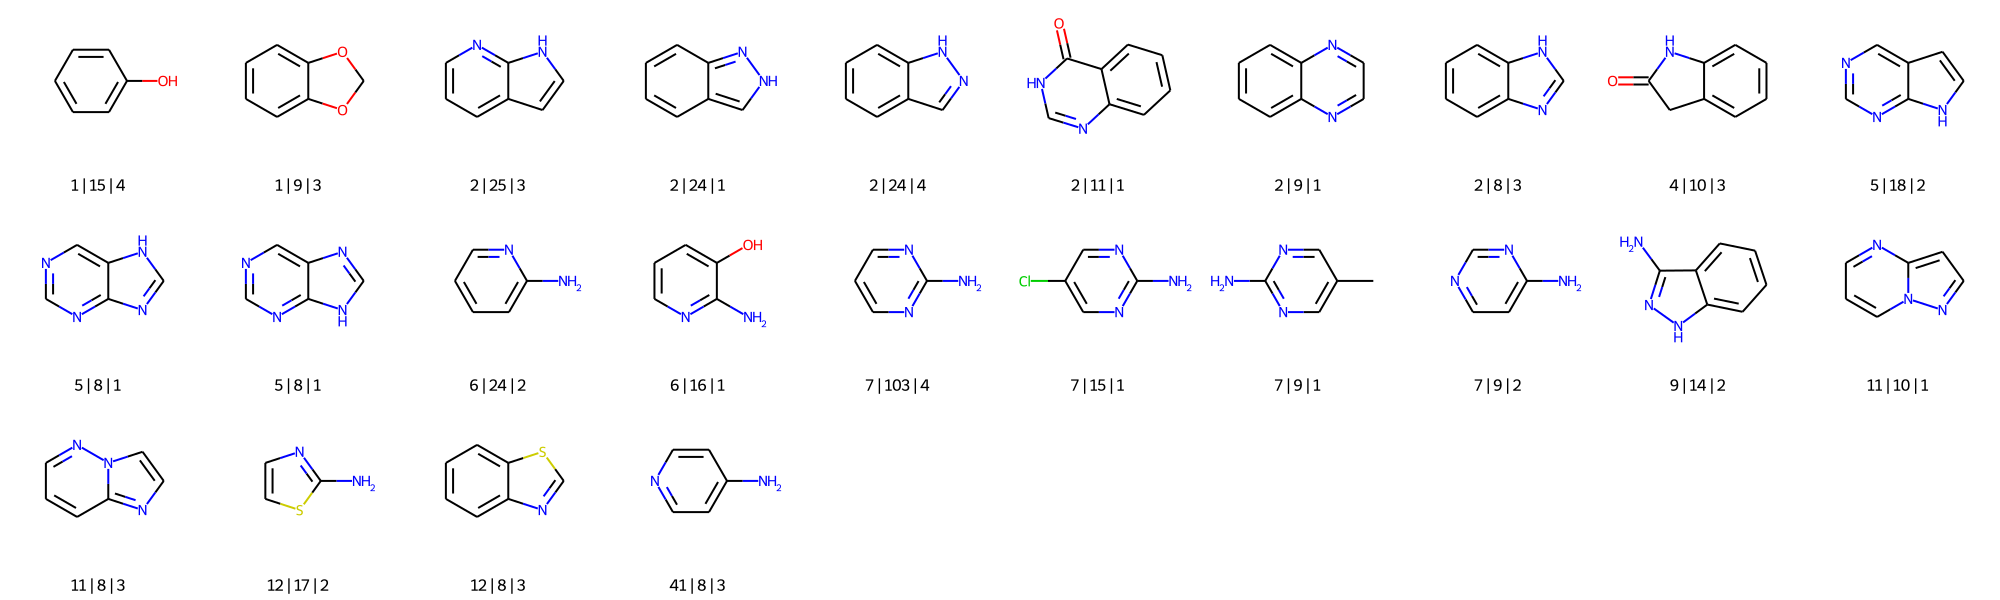

In [44]:
filters.plots.most_common_in_subset(fragment_library_orig, clustered_fragments_custom, "AP")

Legend: subset cluster ID | fragment count inside FP in complete fragment library | fragment subpocket count in subset


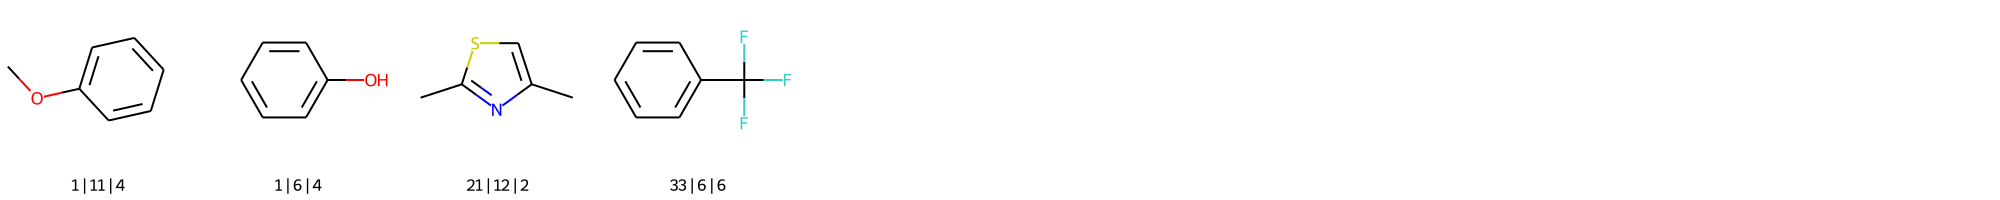

In [45]:
filters.plots.most_common_in_subset(fragment_library_orig, clustered_fragments_custom, "FP") 

Legend: subset cluster ID | fragment count inside GA in complete fragment library | fragment subpocket count in subset


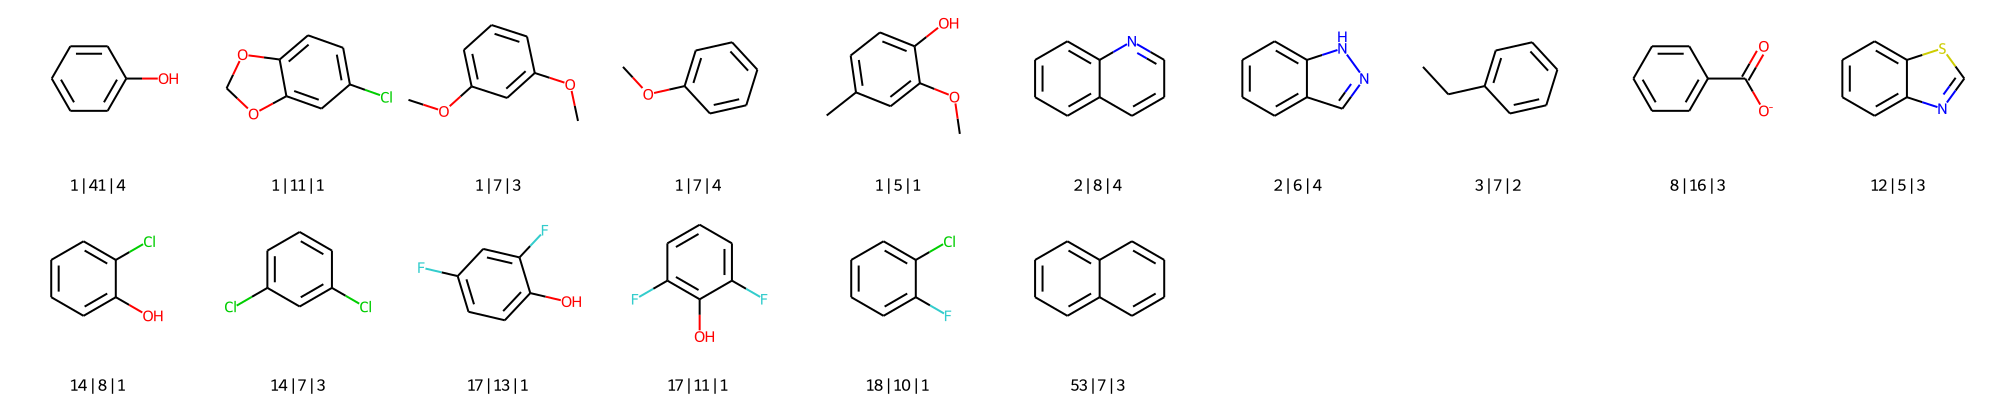

In [46]:
filters.plots.most_common_in_subset(fragment_library_orig, clustered_fragments_custom, "GA")

Legend: subset cluster ID | fragment count inside SE in complete fragment library | fragment subpocket count in subset


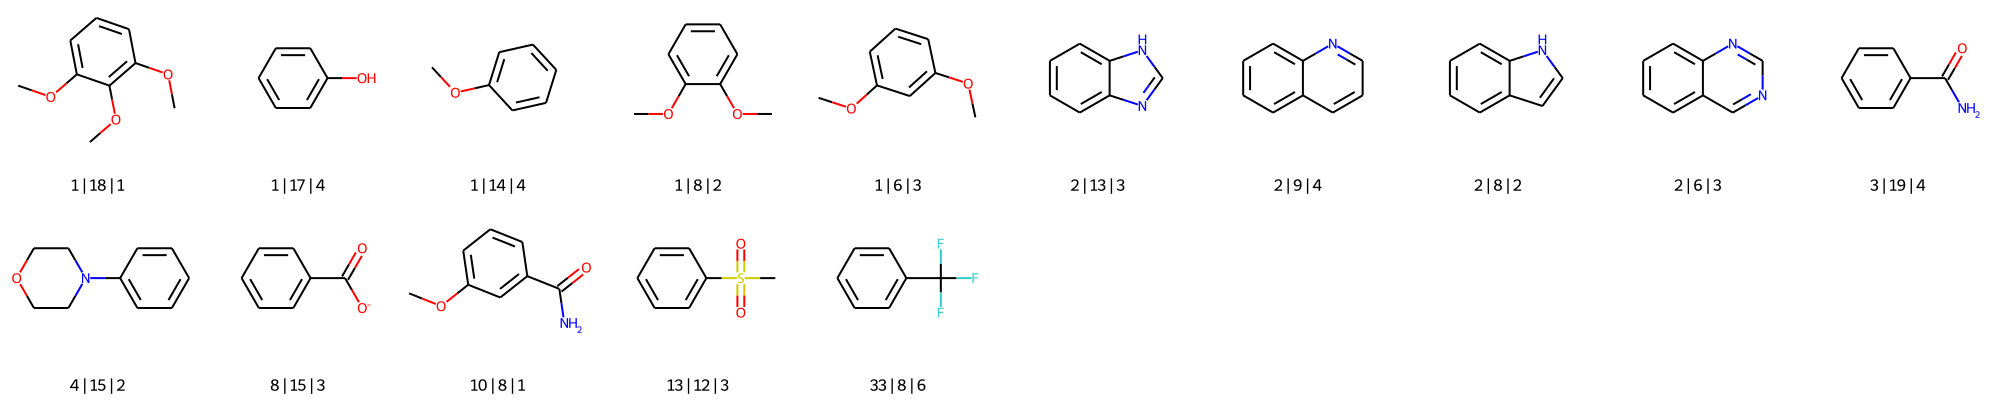

In [47]:
filters.plots.most_common_in_subset(fragment_library_orig, clustered_fragments_custom, "SE")

Legend: subset cluster ID | fragment count inside B1 in complete fragment library | fragment subpocket count in subset


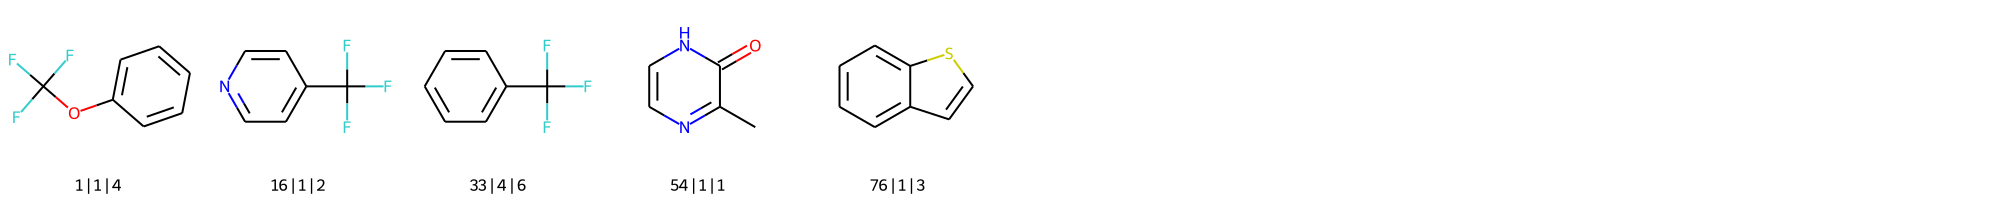

In [48]:
filters.plots.most_common_in_subset(fragment_library_orig, clustered_fragments_custom, "B1")

Legend: subset cluster ID | fragment count inside B2 in complete fragment library | fragment subpocket count in subset


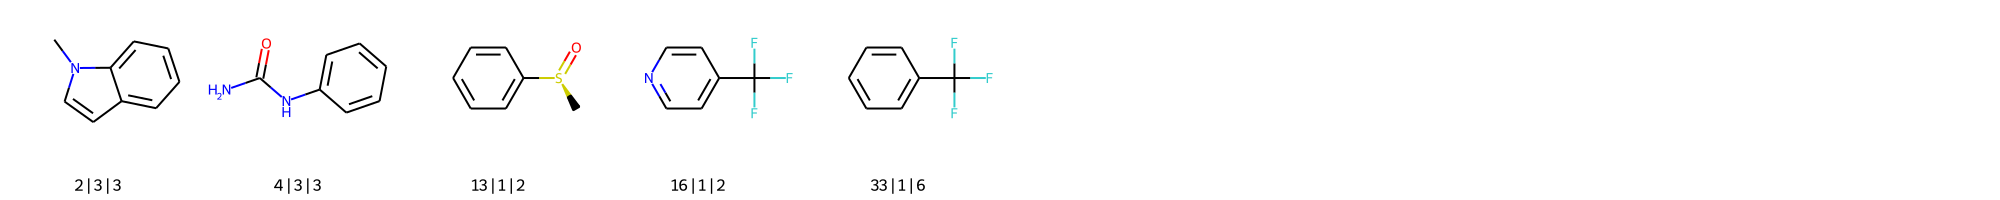

In [49]:
filters.plots.most_common_in_subset(fragment_library_orig, clustered_fragments_custom, "B2")

## 4. Connection frequency between subpockets

Count how often a connection between two subpockets (dummy atoms pointing to adjacent subpockets) appears in the individual libraries and calculate the frequency of each connection.

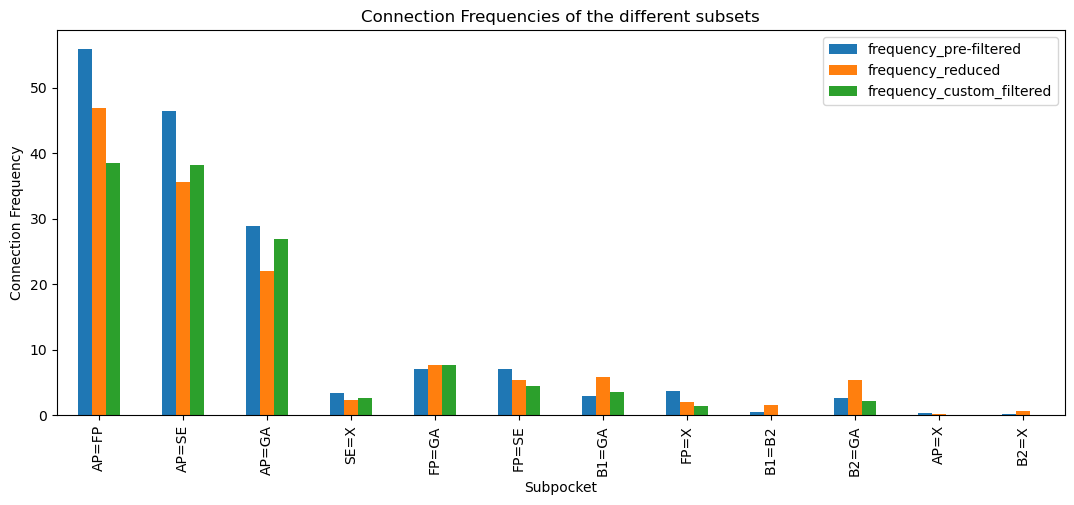

In [59]:
con_frequencies = filters.plots.connection_frequencies(fragment_library, fragment_library_reduced, fragment_library_custom)

In [51]:
con_frequencies

count_pre-filtered  frequency_pre-filtered  count_reduced  \
AP=FP                1024                    56.0            254   
AP=SE                 848                    46.4            193   
AP=GA                 528                    28.9            120   
SE=X                   63                     3.4             13   
FP=GA                 129                     7.1             41   
FP=SE                 128                     7.0             29   
B1=GA                  54                     3.0             32   
FP=X                   68                     3.7             11   
B1=B2                   9                     0.5              8   
B2=GA                  49                     2.7             29   
AP=X                    5                     0.3              1   
B2=X                    3                     0.2              3   

       frequency_reduced  count_custom-filtered  frequency_custom_filtered  
AP=FP               46.9                    140                       38.5  
AP=SE               35.6                    139                       38.2  
AP=GA               22.1                     98                       26.9  
SE=X                 2.4                     10                        2.7  
FP=GA                7.6                     28                        7.7  
FP=SE                5.4                     16                        4.4  
B1=GA                5.9                     13                        3.6  
FP=X                 2.0                      5                        1.4  
B1=B2                1.5                      0                        0.0  
B2=GA                5.4                      8                        2.2  
AP=X                 0.2                      0                        0.0  
B2=X                 0.6                      0                        0.0

## 5. Fragment similarity per subpocket


Calculate the pairwise Tanimoto similarity of the fragments RDKit fingerprints for each fragment library subset.

In [52]:
similarities_per_subpocket = utils.get_fragment_similarity_per_subpocket(pd.concat(fragment_library))
similarities_per_subpocket_reduced = utils.get_fragment_similarity_per_subpocket(pd.concat(fragment_library_reduced))
similarities_per_subpocket_custom = utils.get_fragment_similarity_per_subpocket(pd.concat(fragment_library_custom))
mean_similarities = pd.concat(
    [
        similarities_per_subpocket.groupby('subpocket', sort=False).mean(),
        similarities_per_subpocket_reduced.groupby('subpocket', sort=False).mean(),
        similarities_per_subpocket_custom.groupby('subpocket', sort=False).mean(),
    ],
    axis=1,
)
mean_similarities.columns=["similarity_pre-filtered", "similarity_reduced", "similarity_custom"]
mean_similarities

similarity_pre-filtered  similarity_reduced  similarity_custom
subpocket                                                                
AP                        0.140770            0.111311           0.161415
FP                        0.089126            0.069282           0.129486
SE                        0.102575            0.076425           0.144180
GA                        0.104821            0.075186           0.166848
B1                        0.074256            0.052510           0.143353
B2                        0.091785            0.073320           0.149357

Plot the fragment similarity.

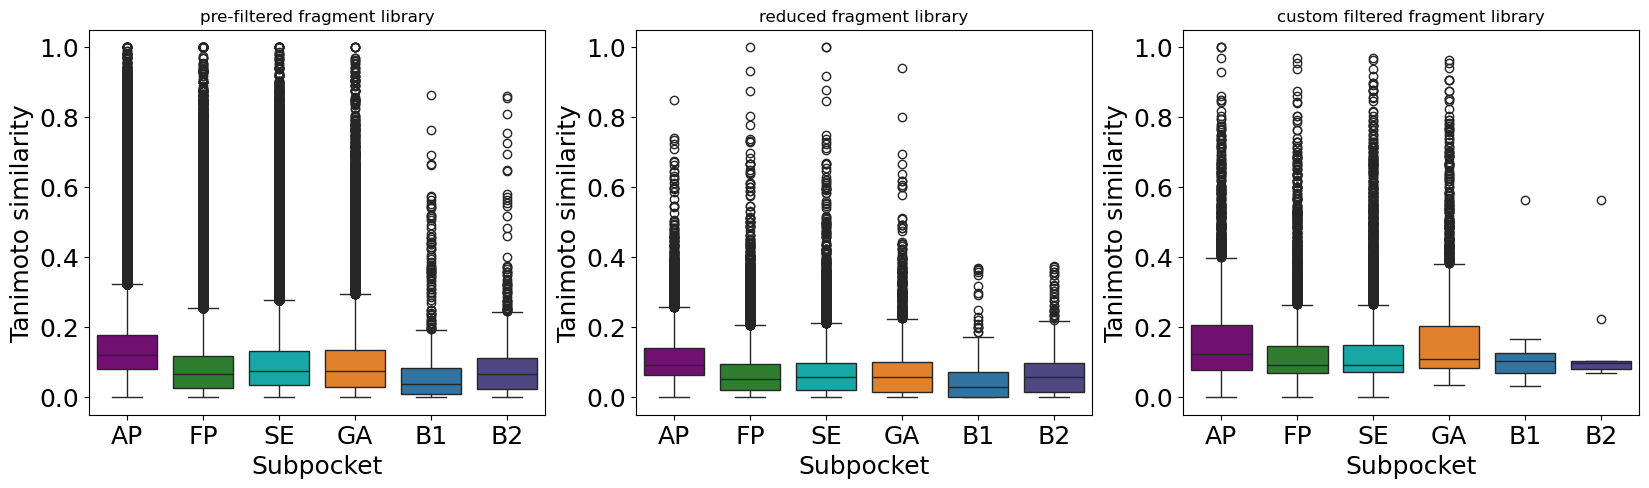

In [53]:
filters.plots.plot_fragment_similarity(
    [similarities_per_subpocket,
     similarities_per_subpocket_reduced,
     similarities_per_subpocket_custom],
    ["pre-filtered fragment library",
    "reduced fragment library",
    "custom filtered fragment library"],
    'Subpocket'
)

## 6. Fragment properties 

Inspect the median values of the fragment properties in each subpocket, namely

    - Number of hyrogen bond donors (# HBD)
    - Number of hydrogen bond acceptors (# HBA)
    - Octanol-water partition coefficient (LogP)
    - Number of heavy atoms (# Heavy atoms)

* 6.1. For each library subset
* 6.2. For every custom filter step

### 6.1. For each library subset

Inspect the median values of the fragment properties for each subpocket.

 pre-filtered fragment library 


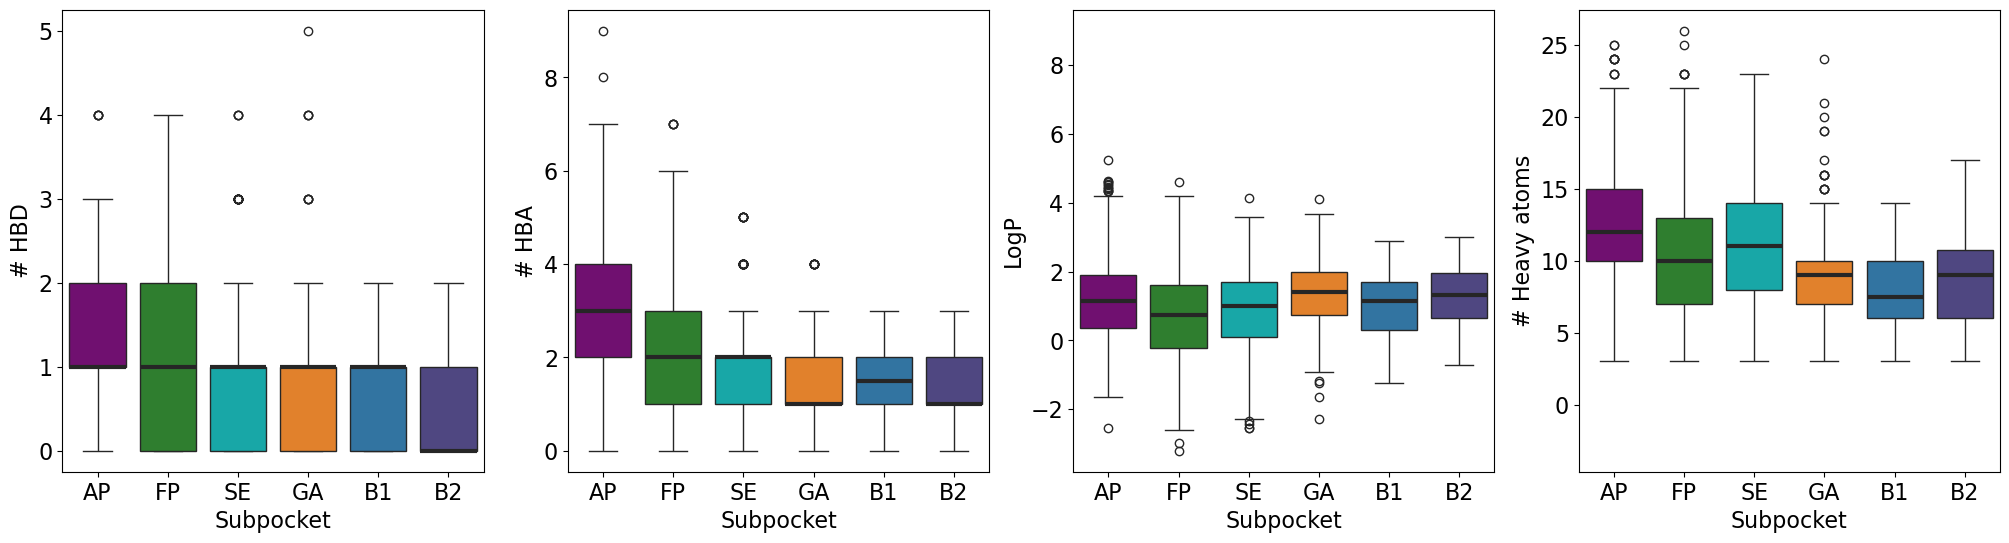

 reduced fragment library 


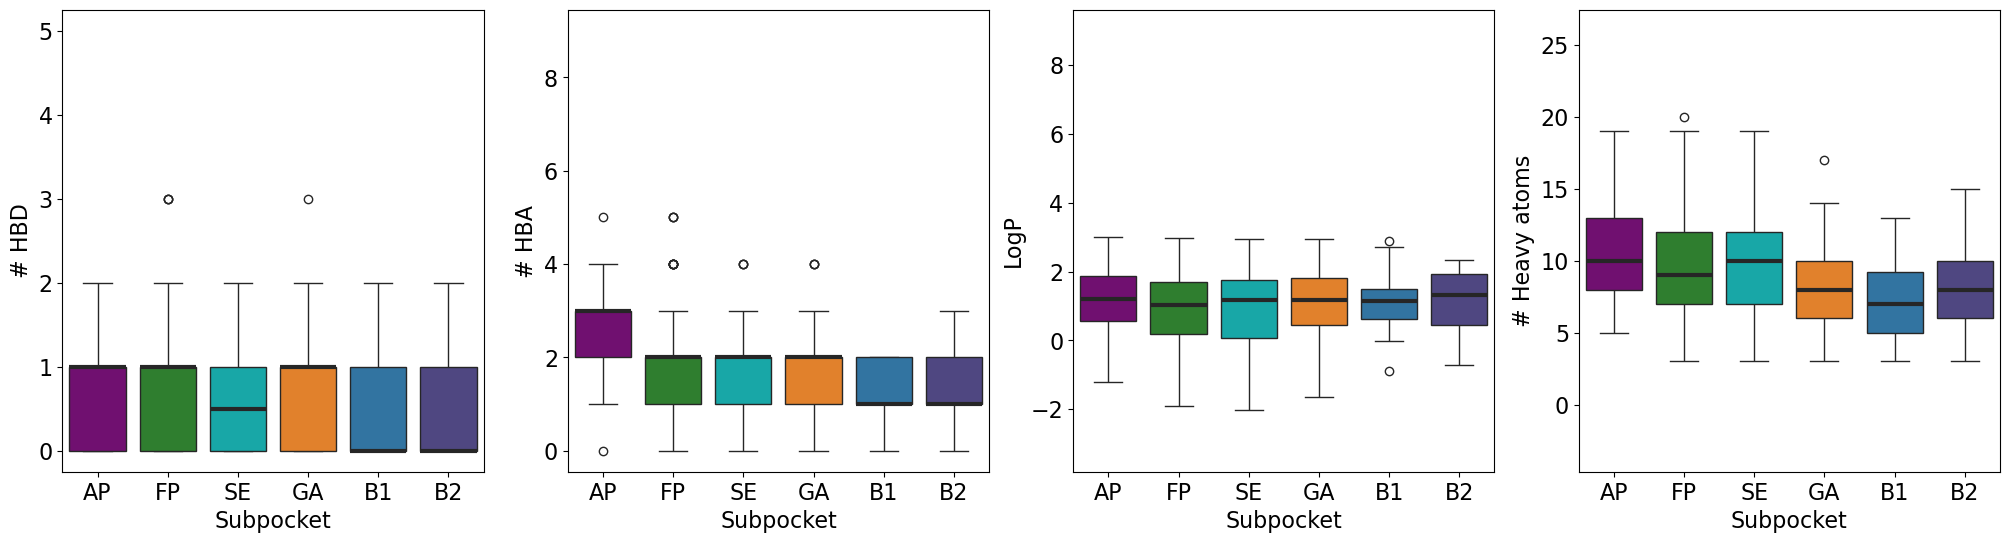

 custom filtered fragment library 


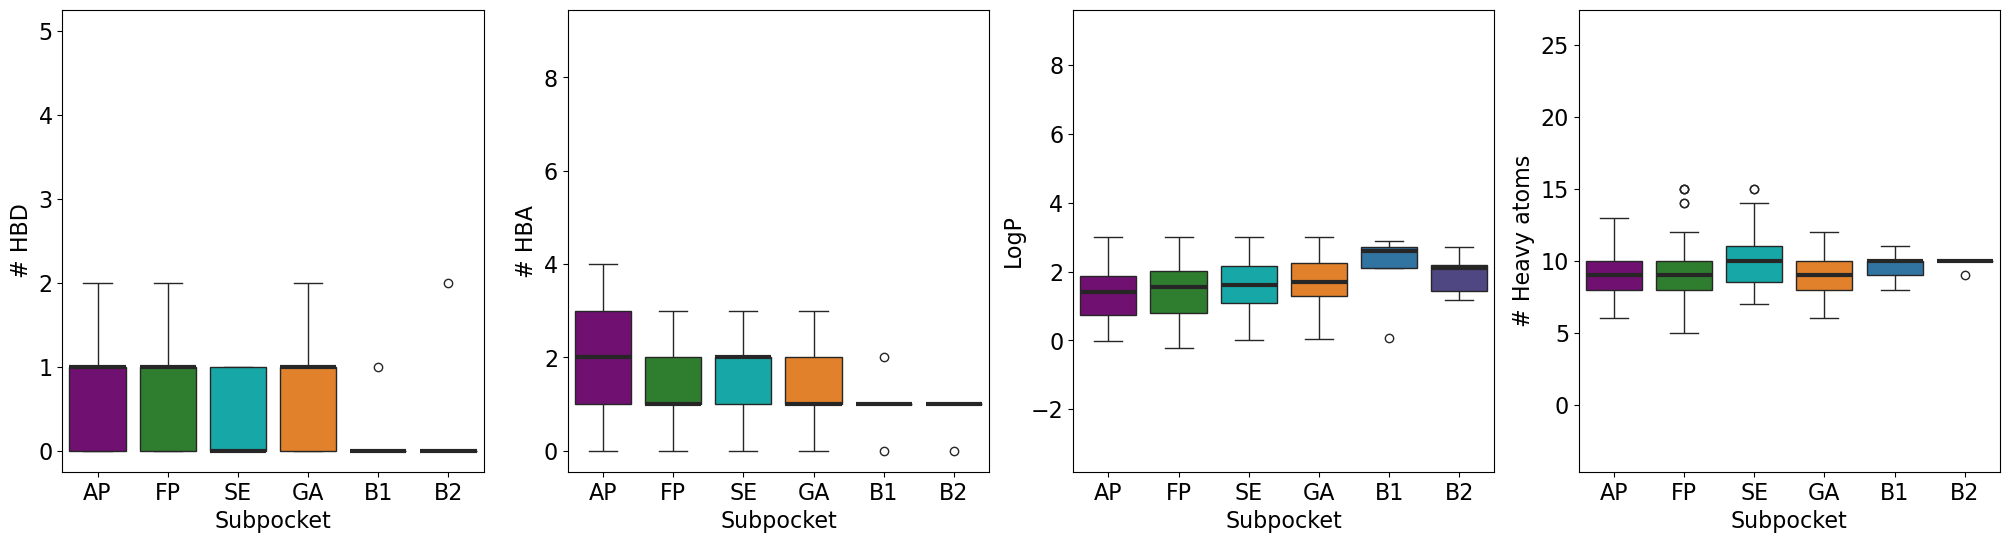

In [54]:
filters.analysis.get_descriptors(fragment_library, fragment_library_reduced, fragment_library_custom)

### 6.2. For every custom filter step

In [55]:
filter_results = pd.read_csv(PATH_DATA_CUSTOM / "custom_filter_results.csv")
fragment_library_filter_res, bool_keys = filters.analysis.filter_res_in_fraglib(fragment_library, filter_results)

 pre-filtered fragment library 


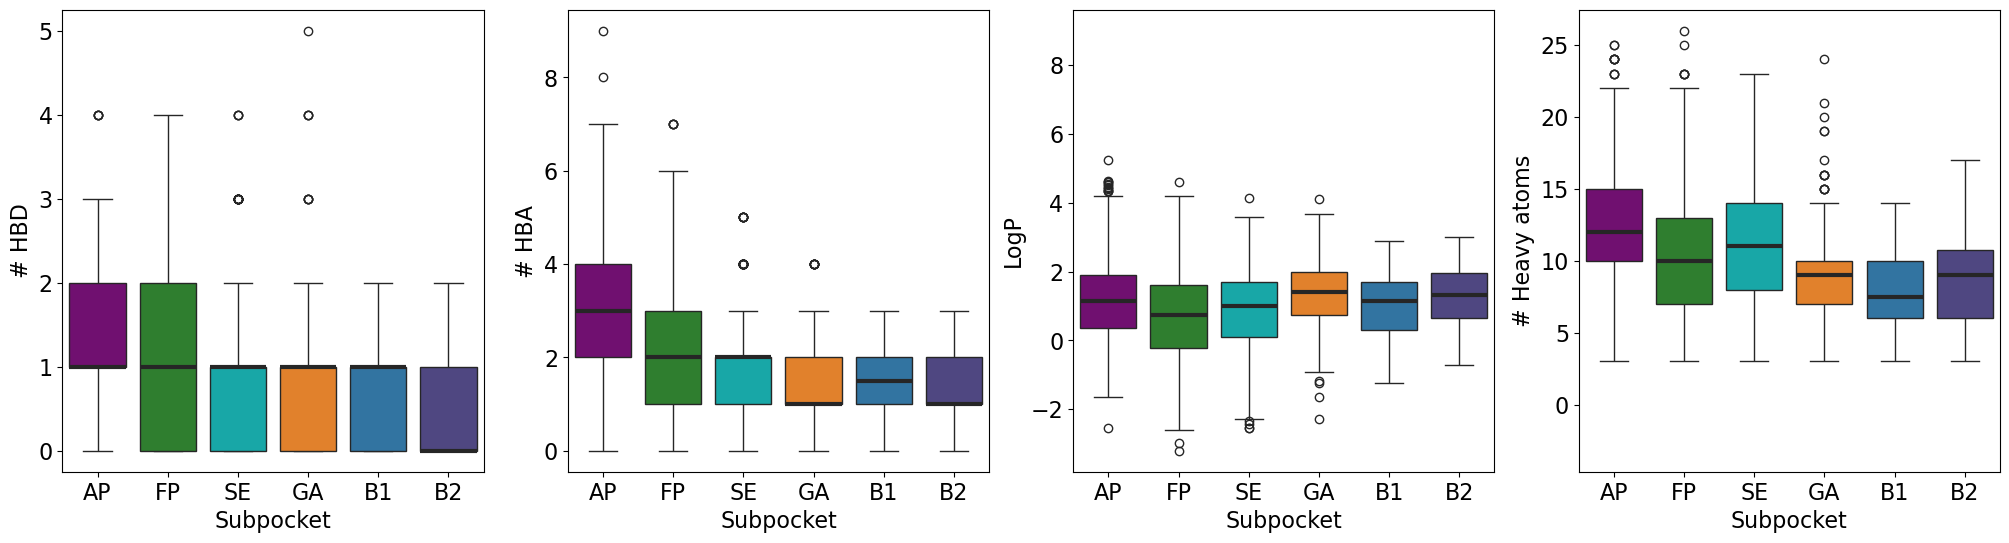

 pains filtered 


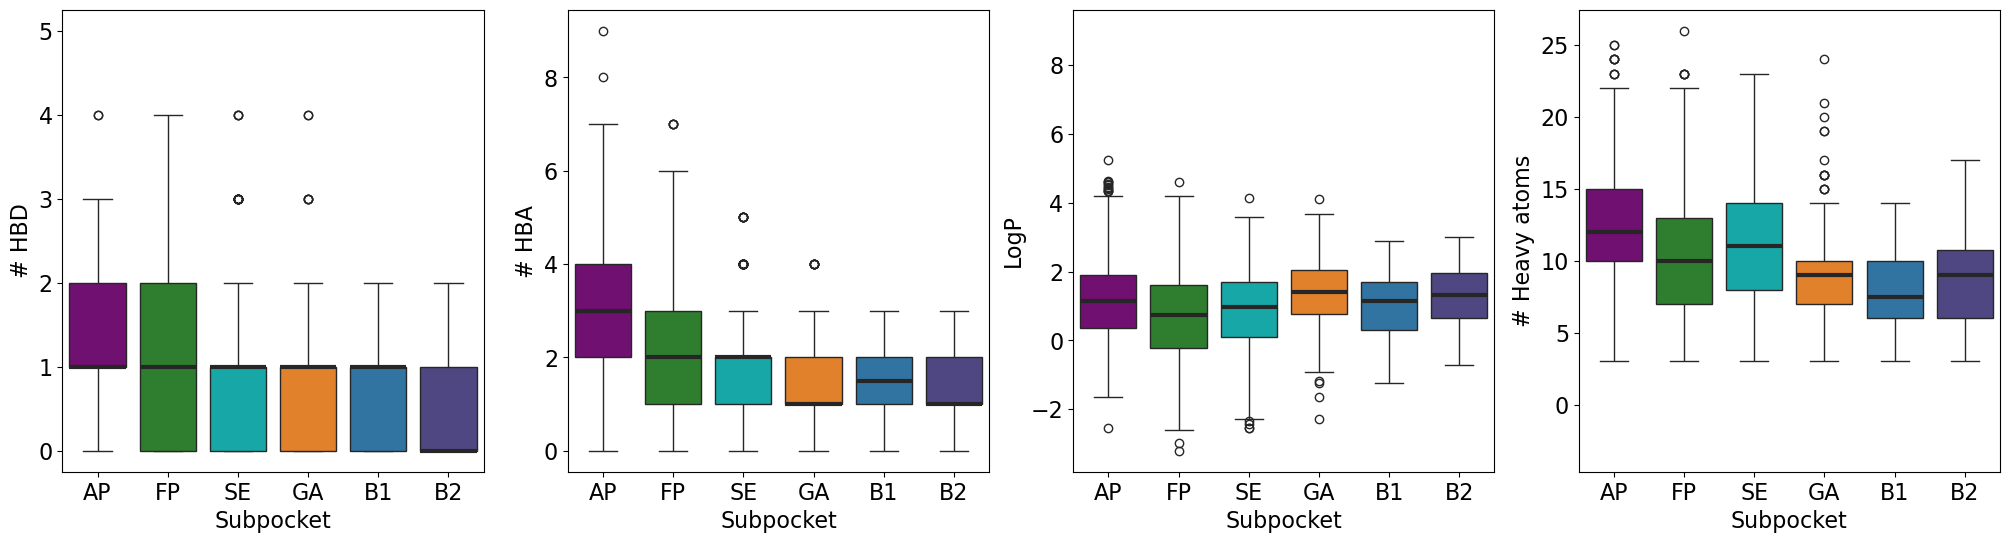

 brenk filtered 


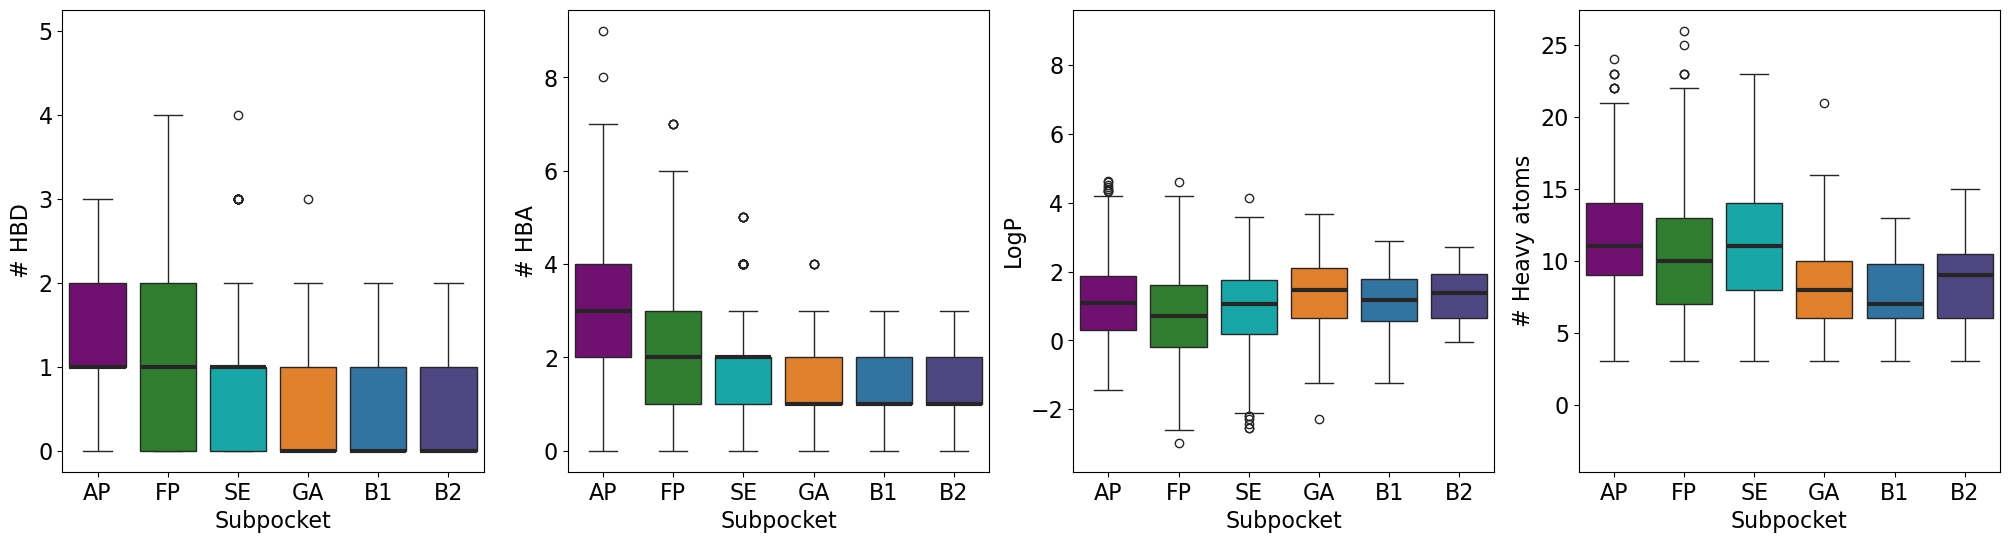

 ro3 filtered 


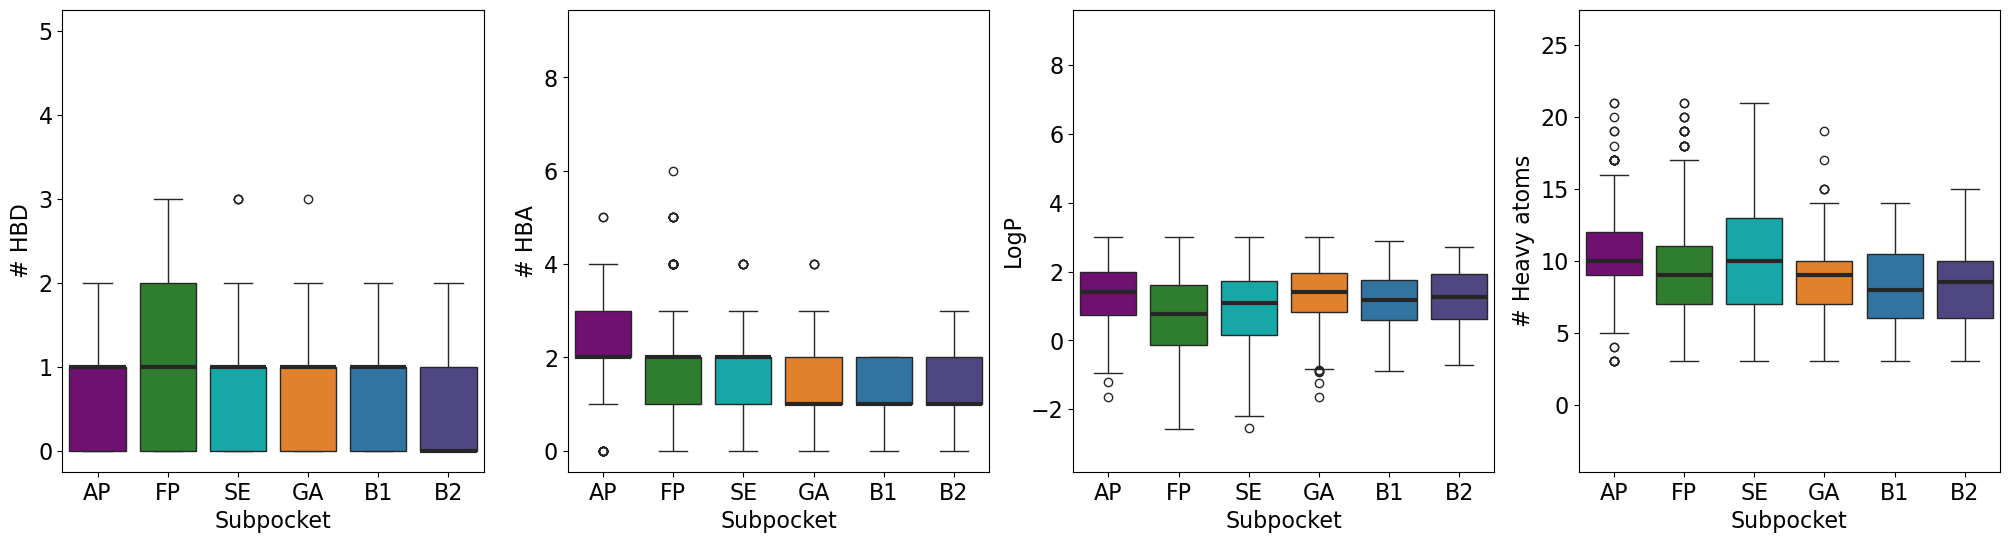

 qed filtered 


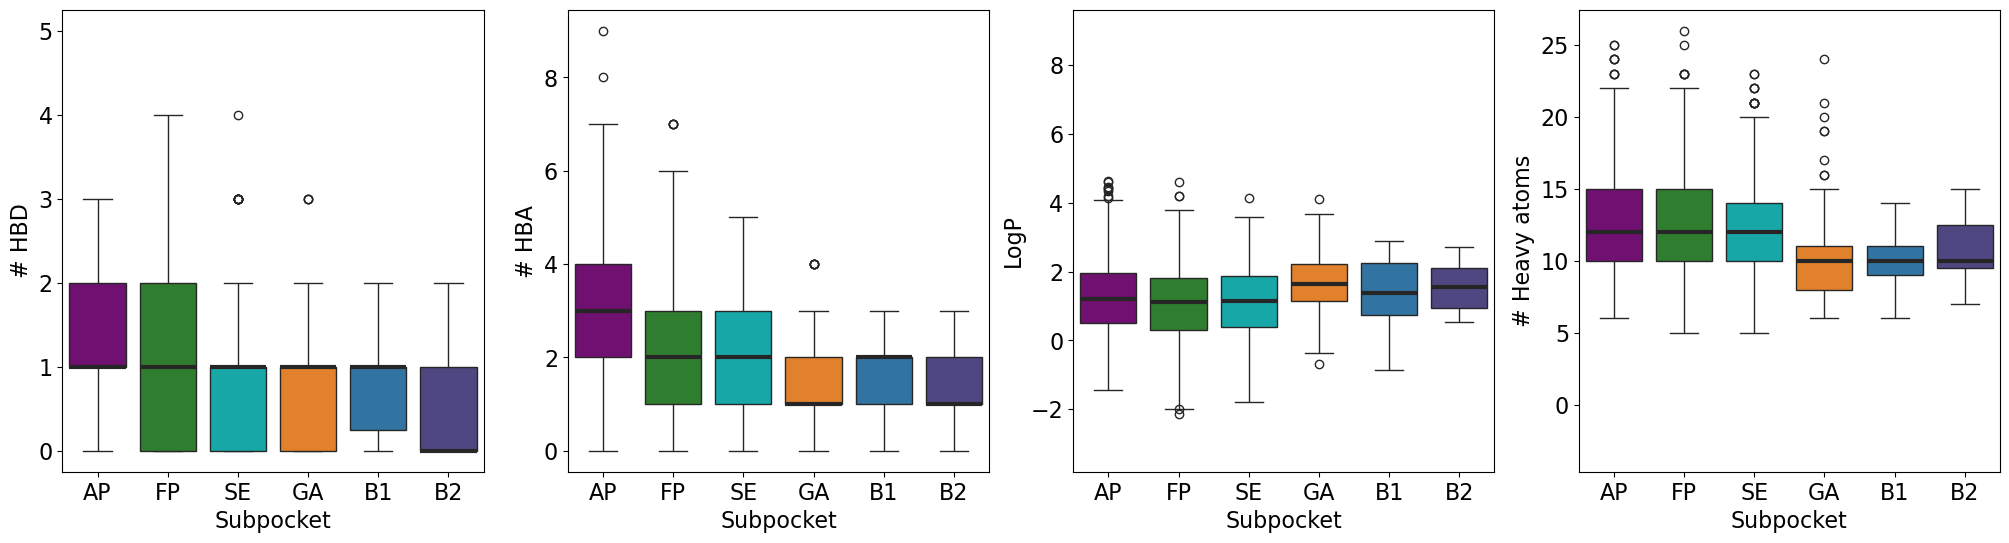

 bb filtered 


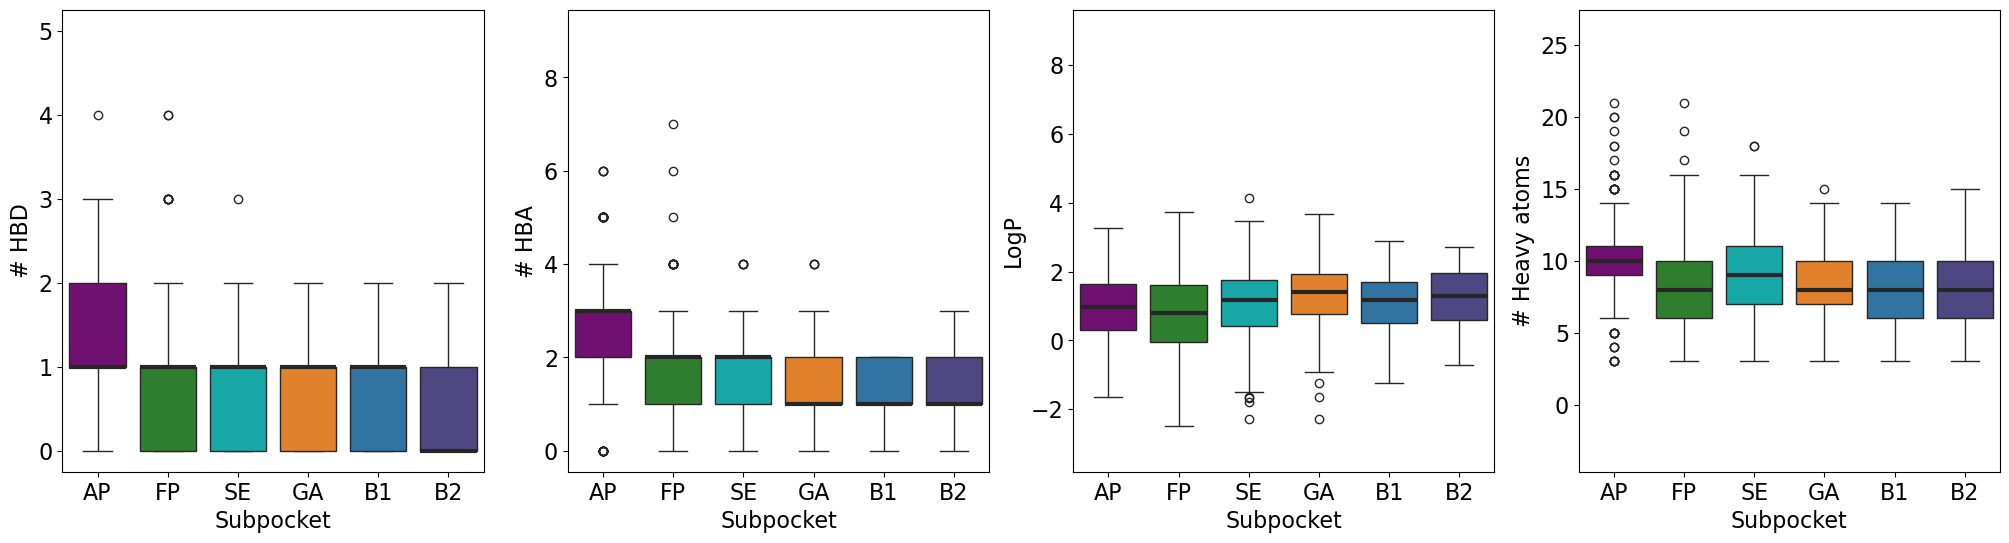

 syba filtered 


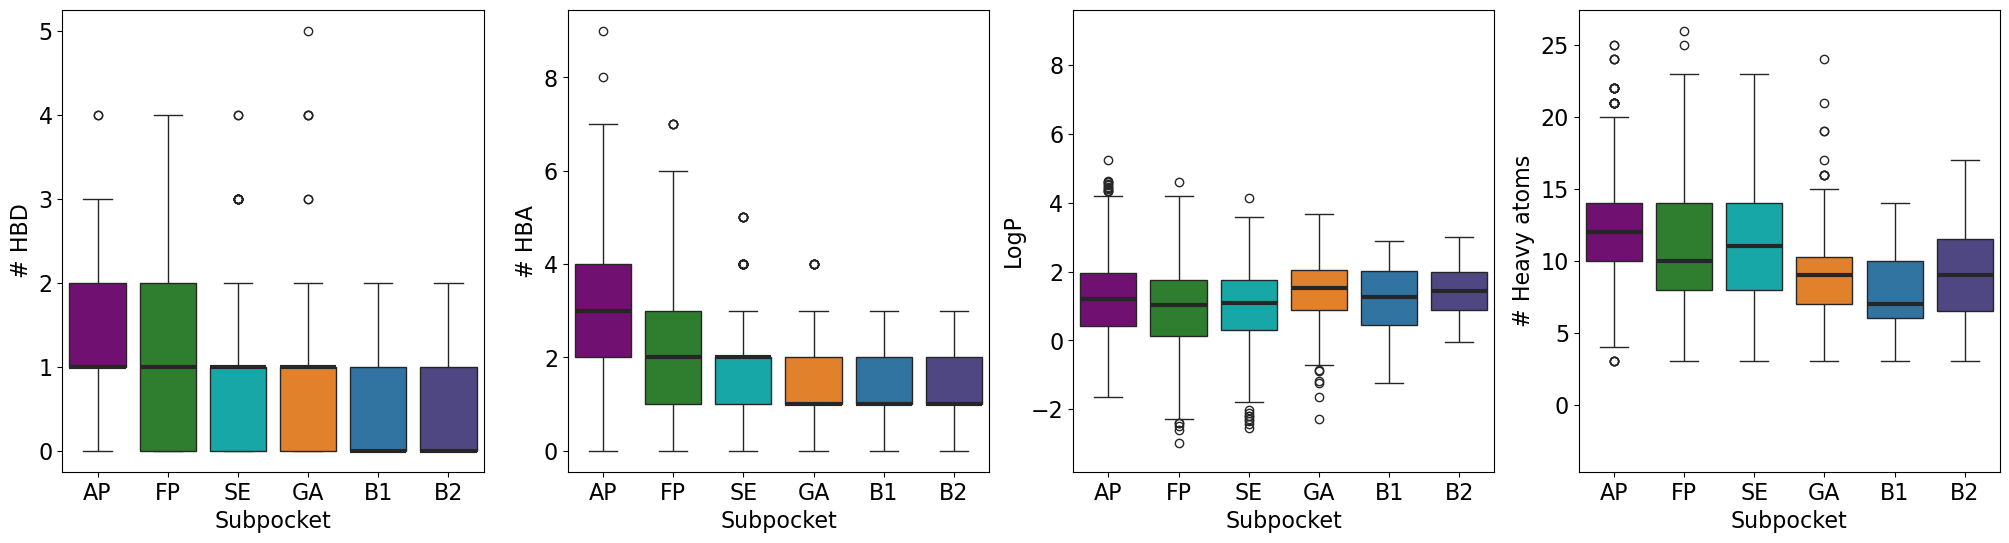

In [56]:
descriptors = filters.analysis.get_descriptors_filters(fragment_library_filter_res, bool_keys)

## 7. Development of number of fragments per subpocket during custom filtering

Inspect the number of fragments filtered out by each custom filtering step, assuming  to remove the fragments not passing after each filtering step.

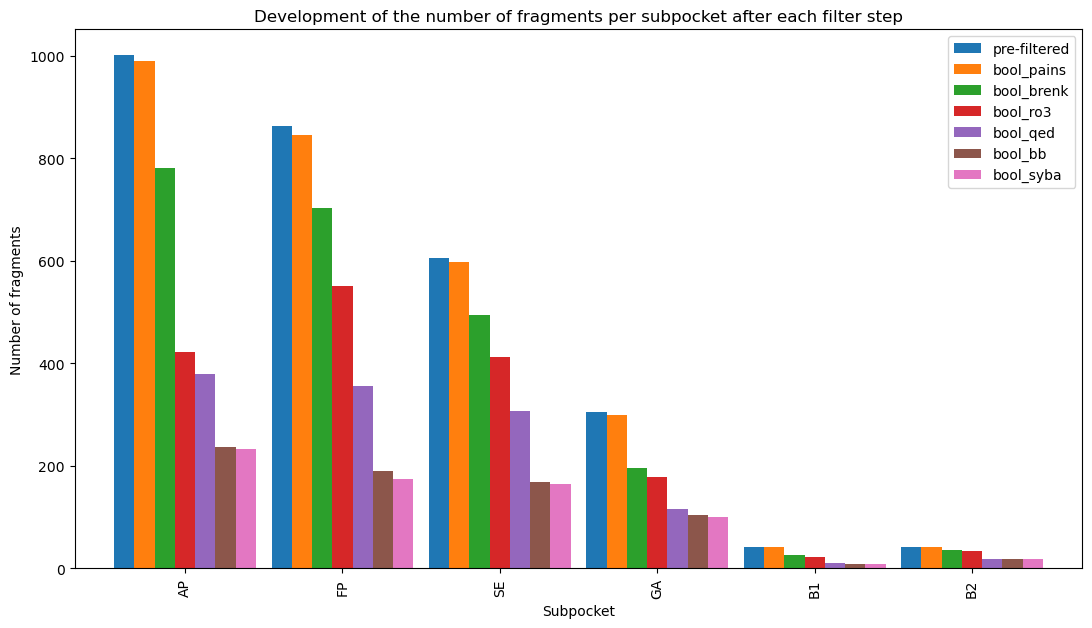

In [60]:
update_results = filters.plots.num_frags_development(filter_results)

In [58]:
update_results = pd.concat([update_results, update_results.sum().rename("Total").to_frame().T])
update_results

pre-filtered  bool_pains  bool_brenk  bool_ro3  bool_qed  bool_bb  \
AP             1001         990         781       422       379      236   
FP              862         845         702       550       356      190   
SE              606         598         494       413       307      169   
GA              306         300         195       179       116      104   
B1               42          42          26        23        10        9   
B2               42          42          36        35        19       18   
Total          2859        2817        2234      1622      1187      726   

       bool_syba  
AP           233  
FP           174  
SE           165  
GA           100  
B1             9  
B2            18  
Total        699